<div class="alert alert-info">
<b>Комментарий студента:</b> Привет, Кирилл! Было приятно ещё раз почитать твои развёрнутые комментарии. Они помогли разобраться со спецификой проекта.

Постфактум проделанной работы я понимаю, что, кажется, почти не оставил комментариев, но если они есть, то должны быть выделены синим фоном. Изменения непосредственно в тексте проекта, как и в прошлый раз, я выделил <font color='green'>зелёным цветом.</font> В целом, проект переработан почти полностью, начиная с исследовательского анализа.
    
И ещё есть просьба. Изначально я хотел перебрать гиперпараметры с помощью OptunaSearchCV, но, похоже, так и не смог грамотно собрать словари. Может, найдётся какой-нибудь материал, который поможет мне разобраться в будущем.
</div>

# Исследование пользовательской активности интернет-магазина

**Описание проекта**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Поставлена задача: разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

<a class="anchor"  id="0"><a/>
**Содержание**

- [1 Загрузка данных](#1)
  - [1.1 Обзор данных о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении](#1.1)
  - [1.2 Обзор данных о выручке, которую получает магазин с покупателя](#1.2)
  - [1.3 Обзор данных о времени, которое покупатель провёл на сайте](#1.3)
  - [1.4 Обзор данных о среднемесячной прибыли продавца за последние 3 месяца](#1.4)
- [2 Предобработка данных](#2)
- [3 Исследовательский анализ данных](#3)
  - [3.1  Анализ данных market_main](#3.1)
  - [3.2  Анализ данных market_money](#3.2)
  - [3.3  Анализ данных market_time](#3.3)
  - [3.4  Анализ данных money_mean_month](#3.4)
  - [3.5 Отбор активных клиентов](#3.5)
- [4 Объединение таблиц](#4)
- [5 Корреляционный анализ](#5)
- [6 Использование пайплайнов](#6)
- [7 Анализ важности признаков](#7)
- [8 Сегментация покупателей](#8)
- [9 Общий вывод](#9)

<a id="1"><a/>
## Загрузка данных

In [1]:
!pip install -U scikit-learn -q
!pip install matplotlib==3.5.1 -q
!pip install shap -q
!pip install phik -q
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
import shap
import phik

#!pip install optuna.integration -q 
#!pip install optuna -q
#from optuna.integration import OptunaSearchCV
#from optuna import distributions

Передадим данные следующим переменным:

- **market_main**: данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- **market_money**: данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- **market_time**: данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- **money_mean_month**: данные о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [2]:
market_main = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money_mean_month = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')

<a id="1.1"><a/>
### Обзор данных о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении

Изучим самый объёмный датасет с информацией о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

In [3]:
market_main.head(20)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


Сразу можем обратить внимание на наличие неявного дубликата среди значений признака **Тип сервиса**. Изучим датафрейм на предмет пропусков и соотвествие типов данных.

In [4]:
market_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

В датасете 1300 записей без пропусков, типы данных соответствуют изученным значениям. Изучим сводную статистику признаков.

In [5]:
market_main.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


In [6]:
market_main.describe(include='object').T

,count,unique,top,freq
Покупательская активность,1300,2,Прежний уровень,802
Тип сервиса,1300,3,стандарт,914
Разрешить сообщать,1300,2,да,962
Популярная_категория,1300,6,Товары для детей,330


Сводная статистика данных не указывает на наличие аномальных значений среди количественных признаков. Признак типа сервиса имеет три уникальных значения, что дополнительно подтверждает наличие неяного дубликата. Проверим датасет на наличие явных дубликатов.

In [7]:
market_main.duplicated().sum()

0

Явные дубликаты отсутствуют. 

**Промежуточный вывод:**

- Датафрейм **market_main** содержит 1300 наблюдений по 9-ти признакам.
- По сводной статистике не выявили аномальных значений.
- Признак "Тип сервиса" содержит неявный дубликат среди значений.

[Назад к содержанию](#0)

<a id="1.2"><a/>
### Обзор данных о выручке, которую получает магазин с покупателя

Взглянем на первые 20 строк.

In [8]:
market_money.head(20)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


Если не учитывать глубоких моральных страданий стажёра от способа описания месяца предшествующего предыдущему, то с данными на первый взгляд всё в порядке. Изучим данные на наличие пропусков и проверим соответствие типов данных.

In [9]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Всего в датафрейме 3900 строк с данными без пропущенных значений. Типы данных соответствуют описанным значениям.

In [10]:
market_money.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


In [11]:
market_money.describe(include='object').T

,count,unique,top,freq
Период,3900,3,предыдущий_месяц,1300


Сводная статистика не показала аномальных значений. Максимальное значение выручки 106862 вероятно будет сильно выделяться из выборки. Однако, судя по разнице между медианным значением и средним, выбросов должно быть не так много.

**Промежуточный вывод:** датафрейм **market_money** содержит 3900 наблюдений по трём признакам.

[Назад к содержанию](#0)

### Обзор данных о времени, которое покупатель провёл на сайте

Изучим первые 20 строк датафрейма **market_time**.

In [12]:
market_time.head(20)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


Видимо, в датасете собраны данные по каждому пользователю за последние два месяца. Необычных значений не наблюдаем. Есть незначительная опечатка в одном из значений периода, можно подправить при предобработке. Изучим данные на наличие пропусков и проверим соответствие типов данных.

In [13]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Пропущенных значений нет, типы данных соответствуют изученным значениям. Взглянем на сводную статистику.

In [14]:
market_time.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


In [15]:
market_time.describe(include='object').T

,count,unique,top,freq
Период,2600,2,предыдцщий_месяц,1300


Аномальных значений нет.

**Промежуточный вывод:** датафрейм **market_time** состоит из 2600 строк по трём признакам.

[Назад к содержанию](#0)

### Обзор данных о среднемесячной прибыли продавца за последние 3 месяца

Изучим датафрейм **money_mean_month**.

In [16]:
money_mean_month.head(20)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


Изучим данные на наличие пропусков и проверим соответствие типов данных.

In [17]:
money_mean_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Пропусков нет, типы данных в норме.

In [18]:
money_mean_month.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
Прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


**Промежуточный вывод**: датафрейм **money_mean_month** содержит 1300 строк наблюдений по двум признакам.

[Назад к содержанию](#0)

<a id="2"><a/>
## Предобработка данных

**market_main**:

Мы обнаружили неявный дубликат в значениях признака "Тип сервиса", самое время это исправить.

In [19]:
# Создадим функцию, которая приведёт ошибочную запись в норму, и применим её к датафрейму market_main.
def service_correct(type):
    if type == 'стандартт':
        return 'стандарт'
    else:
        return type
    
market_main['Тип сервиса'] = market_main['Тип сервиса'].apply(service_correct)
# Изучим уникальные значения типов сервиса.
market_main['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

Проверим, не появились ли явные дубликаты.

In [20]:
market_main.duplicated().sum()

0

Данные приведены в надлежащий вид.

Также, чтобы избежать ошибок при построении моделей, стоит сделать значения более однородными. Приведём все строковые значения к нижнему регистру.

In [21]:
for column in ['Покупательская активность', 'Популярная_категория']:
    market_main[column] = market_main[column].str.lower()

In [22]:
market_main['Популярная_категория'] = market_main['Популярная_категория'].apply(lambda x: x.replace('косметика и аксесуары', 'косметика и аксессуары'))

In [23]:
def columns_monotonizer(columns):
    return [i.lower().replace(' ', '_') for i in columns]

market_main.columns = columns_monotonizer(market_main.columns)

**market_money**:

Также поправим значения в признаке "Период" датафрейма **market_money** <s>чисто из вредности</s> с целью соблюдения норм русского языка и поддержки личного ментального здоровья.

In [24]:
def month_correct(vorvorhergehende):
    if vorvorhergehende == 'препредыдущий_месяц':
        return 'предпредыдущий месяц'
    if vorvorhergehende == 'предыдущий_месяц':
        return 'предыдущий месяц'
    if vorvorhergehende == 'текущий_месяц':
        return 'текущий месяц'
    else:
        return vorvorhergehende

market_money['Период'] = market_money['Период'].apply(month_correct)

In [25]:
market_money.columns = columns_monotonizer(market_money.columns)

**market_time**:

Подправим опечатку и поменяем разделитель на пробел в пользу однородности данных.

In [26]:
market_time['Период'] = market_time['Период'].apply(lambda x: x.replace('предыдцщий_месяц', 'предыдущий месяц'))
market_time['Период'] = market_time['Период'].apply(lambda x: x.replace('_', ' '))

In [27]:
market_time.columns = columns_monotonizer(market_time.columns)
money_mean_month.columns = columns_monotonizer(money_mean_month.columns)

**Итоги предобработки:**

- Удалён неявный дубликат "стандартт" в признаке тип_сервиса.
- Названия столбцов и значений сделаны более однотипными.
- Внесены лёгкие эстетические правки.

[Назад к содержанию](#0)

<a id="3"><a/>
## Исследовательский анализ данных

<a id="3.1"><a/>
### Анализ данных market_main

При изучении сводной статистики во время загрузки данных аномальных значений мы не заметили. Взглянем на распределение данных по графикам.

In [28]:
# Функция для построения гистограммы и диаграммы размаха.
def hist_und_box(df, column, axes_name, title):
    sns.set(rc={'figure.figsize': (15, 5)})
    fig, axes = plt.subplots(1, 2)
    
    sns.histplot(data=df, bins=30, x=column, ax=axes[0], color='green', hue='покупательская_активность')
    axes[0].set(ylabel='Количество клиентов', xlabel=axes_name)
    
    sns.boxplot(data=df[column], ax=axes[1], color='green')
    axes[1].set(ylabel=axes_name)
    
    plt.suptitle(title)
    plt.show()

In [29]:
def hist_und_box_boring(df, column, axes_name, title):
    sns.set(rc={'figure.figsize': (15, 5)})
    fig, axes = plt.subplots(1, 2)
    
    sns.histplot(data=df, bins=30, x=column, ax=axes[0], color='green')
    axes[0].set(ylabel='Количество клиентов', xlabel=axes_name)
    
    sns.boxplot(data=df[column], ax=axes[1], color='green')
    axes[1].set(ylabel=axes_name)
    
    plt.suptitle(title)
    plt.show()

In [30]:
# Функция для построения круговой диаграммы.
def pieplot_creator(df, column, title):
    df_var = df.groupby(column)['id'].count()
    
    plt.pie(df_var, labels=df_var.index, colors=("cyan", "lightgreen"), autopct='%1.2f%%')
    plt.title(title)
    plt.show()

Взглянем ещё раз на сводную статистику количественных признаков.

In [31]:
market_main.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


**Среднемесячное значение маркетинговых коммуникаций компании (маркет актив 6 мес)**:

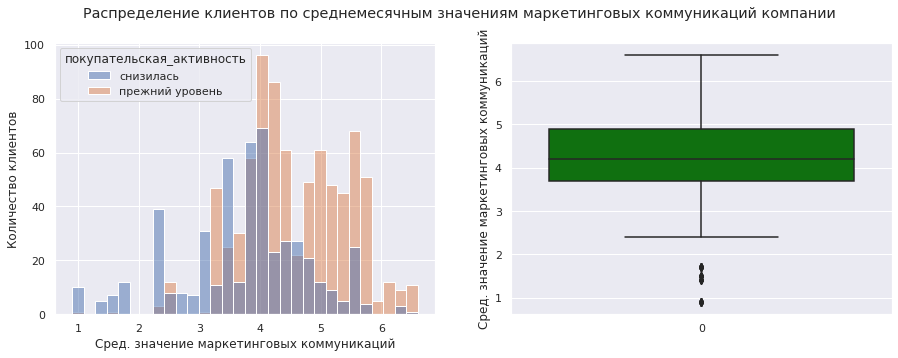

In [32]:
hist_und_box(market_main.reset_index(drop=True), 'маркет_актив_6_мес', 'Сред. значение маркетинговых коммуникаций', 'Распределение клиентов по среднемесячным значениям маркетинговых коммуникаций компании')

Значения менее, чем примерно 2.4, воспринимаются ящиком с усами как статистические выбросы.

Можем попробовать ввести категореальный признак, чтобы избавиться от выбросов. При корреляционном анализе изучим, какой признак будет лучше коррелировать с целевым.

<font color='green'> Отметим, что значения от 1 до 3 принадлежат пользователям в большей части со снизившейся активностью. Это могут быть пользователи, которые в целом редко посещают сайт. </font>

In [33]:
def market_active_categorize(value):
    if value <= 3:
        return '3 или меньше'
    if value > 3 and value < 5:
        return '3—5'
    if value >= 5:
        return '5 или больше'
    
market_main['market_active_mean_cat'] = market_main['маркет_актив_6_мес'].apply(market_active_categorize)

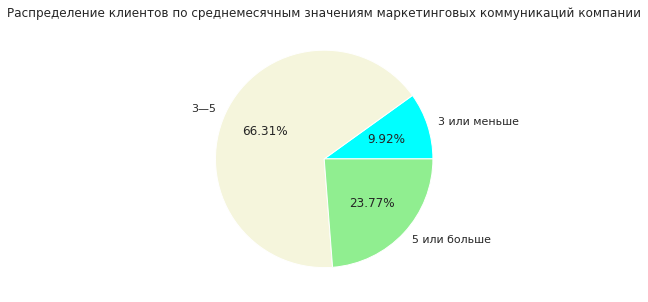

In [34]:
df_var = market_main.groupby('market_active_mean_cat')['id'].count()
    
plt.pie(df_var, labels=df_var.index, colors=("cyan", "beige", "lightgreen", "orange"), autopct='%1.2f%%')
plt.title('Распределение клиентов по среднемесячным значениям маркетинговых коммуникаций компании')
plt.show()

**Количество маркетинговых коммуникаций в текущем месяце (маркет актив тек мес)**:

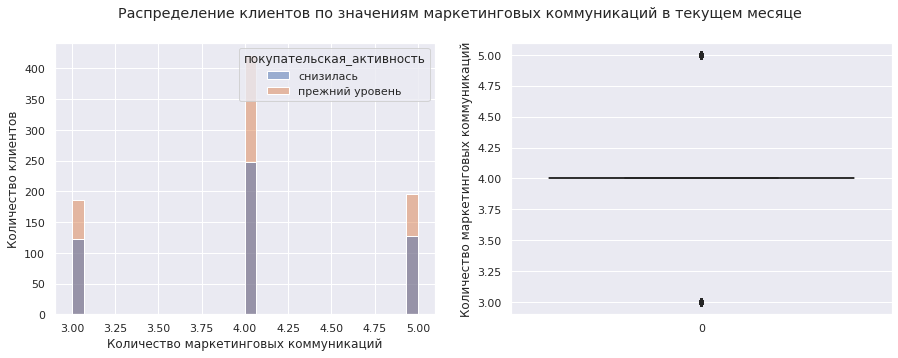

In [35]:
hist_und_box(market_main, 'маркет_актив_тек_мес', 'Количество маркетинговых коммуникаций', 'Распределение клиентов по значениям маркетинговых коммуникаций в текущем месяце')

Видимо, в данном признаке всего три значения. Введём график со столбчатой диаграммой, чтобы отображать такие распределения.

In [36]:
# Функция для построения столбчатой диаграммы.
def countplot_creator(df, column, title, ylabel, xlabel):
    #sns.set_style('whitegrid')
    plt.figure(figsize=(15, 5))
    
    sns.countplot(data=df, x=column, hue='покупательская_активность');
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

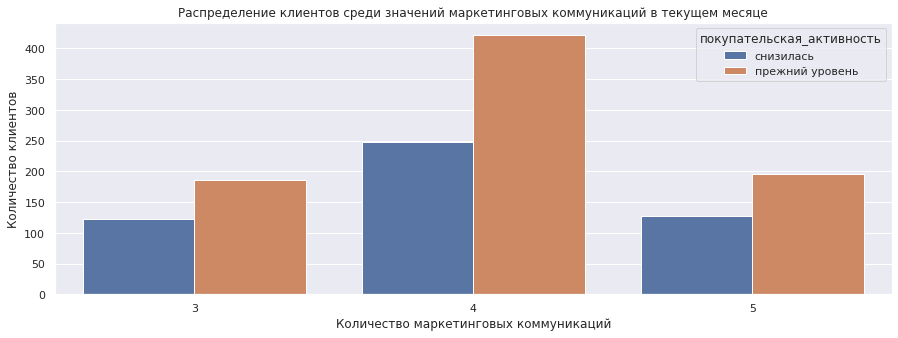

In [37]:
countplot_creator(market_main, 'маркет_актив_тек_мес', 'Распределение клиентов среди значений маркетинговых коммуникаций в текущем месяце', 'Количество клиентов', 'Количество маркетинговых коммуникаций')

Малое количество значений позволяет создать на основе данного признака категриальный.

In [38]:
def market_last_categorize(value):
    if value == 3:
        return 'Три'
    if value == 4:
        return 'Четыре'
    if value == 5:
        return 'Пять'
    
market_main['market_active_last_cat'] = market_main['маркет_актив_тек_мес'].apply(market_last_categorize)

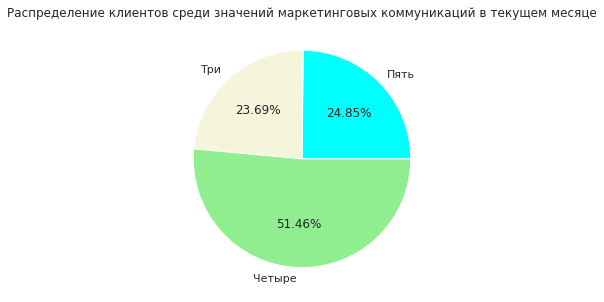

In [39]:
df_var = market_main.groupby('market_active_last_cat')['id'].count()
    
plt.pie(df_var, labels=df_var.index, colors=("cyan", "beige", "lightgreen", "orange"), autopct='%1.2f%%')
plt.title('Распределение клиентов среди значений маркетинговых коммуникаций в текущем месяце')
plt.show()

**Сколько дней прошло с момента регистрации покупателя на сайте (длительность)**:

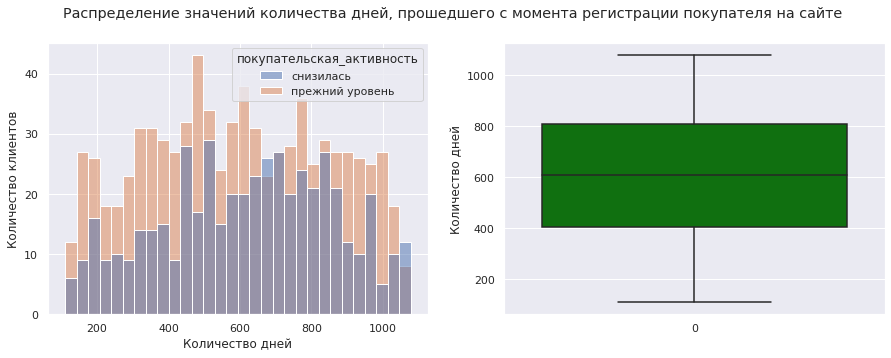

In [40]:
hist_und_box(market_main, 'длительность', 'Количество дней', 'Распределение значений количества дней, прошедшего с момента регистрации покупателя на сайте')

Распределение близко к нормальному. Как мы выяснили из сводной статистики, в выборку не включены пользователи, зарегестрировавшиеся позже, чем 110 дней назад. Вероятно, это и избавляет нас от выбросов, что для наших целей, безусловно, хорошо.

**Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев (акционные покупки)**:

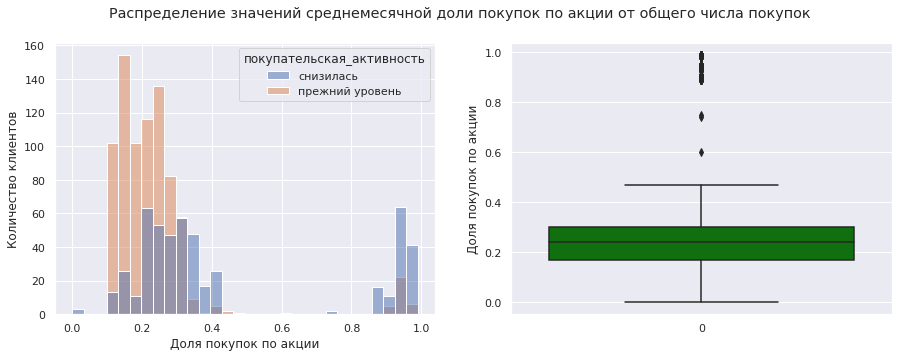

In [41]:
hist_und_box(market_main, 'акционные_покупки', 'Доля покупок по акции', 'Распределение значений среднемесячной доли покупок по акции от общего числа покупок')

Наблюдаем два пика. Можно разделить покупателей на две группы: обычные клиенты и те, кто почти всегда берёт товары только по акции. <font color='green'>Причём высокая доля акционных покупок больше характерна для пользователей со снизившейся активностью. Можно сказать, что у интересующей нас категории покупателей вероятнее снижается активность после завершения акций. Вероятно некоторые категории клиентов получали специальные предложения, иначе бы график был бы более близок к нрмальному распределению.</font> Раз есть чёткая разница, попробуем произвести из этих данных бинарный категориальный признак.

In [42]:
def promotional_purchases_binarization(value):
    if value < 0.7:
        return 'регулярный покупатель'
    elif value > 0.7:
        return 'акционный покупатель'
    
market_main['promotional_purchases_cat'] = market_main['акционные_покупки'].apply(promotional_purchases_binarization)

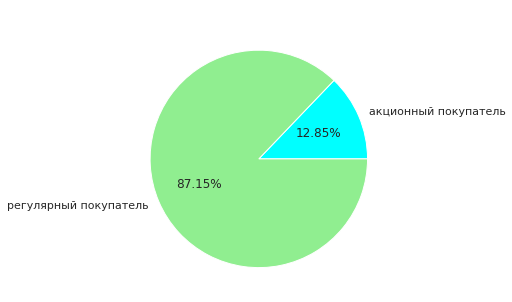

In [43]:
pieplot_creator(market_main, 'promotional_purchases_cat', ' ')

**Сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца (средний просмотр категорий за визит)**:

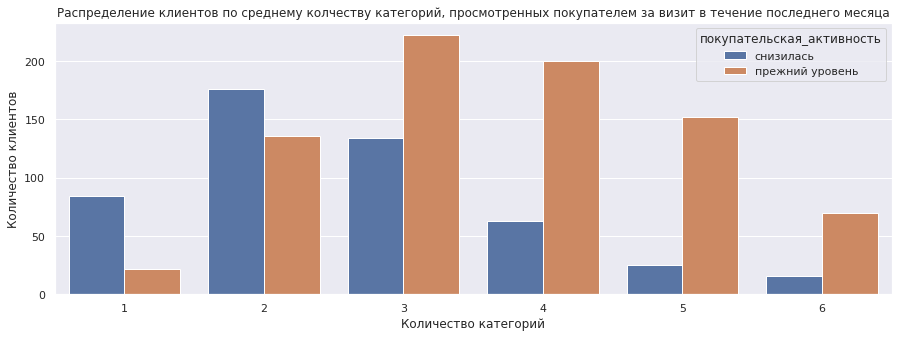

In [44]:
countplot_creator(market_main, 'средний_просмотр_категорий_за_визит', 'Распределение клиентов по среднему колчеству категорий, просмотренных покупателем за визит в течение последнего месяца', 'Количество клиентов', 'Количество категорий')

Распределение похоже на нормальное, смещено влево. <font color='green'> Пользователи со снизившейся активностью в среднем просматривают меньше категорий. В целом уже можно предположить, что низкая активность на сайте более характерна для интересующей нас категории покупателей.</font>

**Общее число неоплаченных товаров в корзине за последние 3 месяца (неоплаченные продукты штук квартал)**:

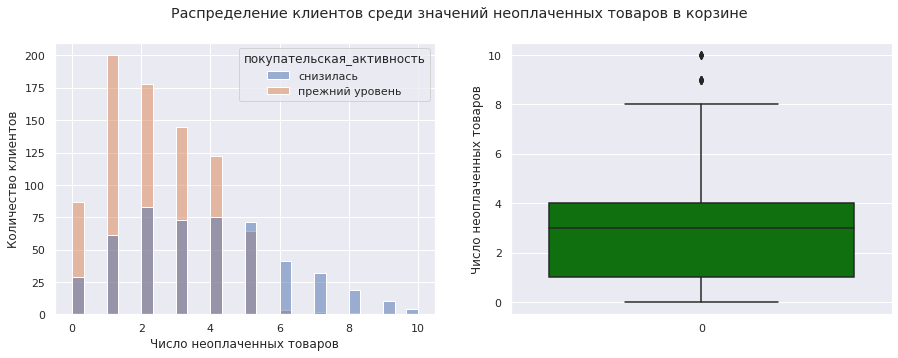

In [45]:
hist_und_box(market_main, 'неоплаченные_продукты_штук_квартал', 'Число неоплаченных товаров', 'Распределение клиентов среди значений неоплаченных товаров в корзине')

Значения неоплаченных товаров выше восьми являются статистически редкими, из-за чего мы получаем выбросы. Создадим категориальный признак; значения выше пяти объединим в одно. <font color='green'> Значения больше пяти более характерныны для пользователей со снизившейся активностью.</font>

In [46]:
def unpaid_products_categorize(value):
    if value == 0:
        return 'не было неоплаченных товаров'
    elif value == 1:
        return 'один'
    elif value == 2:
        return 'два' 
    elif value == 3:
        return 'три'
    elif value == 4:
        return 'четыре'
    elif value == 5:
        return 'пять'
    elif value > 5:
        return 'больше пяти'
    
market_main['unpaid_products_cat'] = market_main['неоплаченные_продукты_штук_квартал'].apply(unpaid_products_categorize)

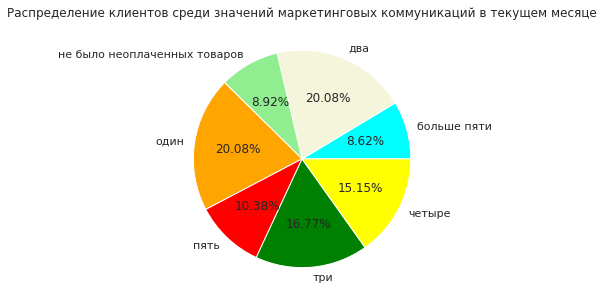

In [47]:
df_var = market_main.groupby('unpaid_products_cat')['id'].count()
    
plt.pie(df_var, labels=df_var.index, colors=("cyan", "beige", "lightgreen", "orange", "red", "green", "yellow"), autopct='%1.2f%%')
plt.title('Распределение клиентов среди значений маркетинговых коммуникаций в текущем месяце')
plt.show()

**Число сбоев, которые коснулись покупателя во время посещения сайта (ошибка сервиса)**:

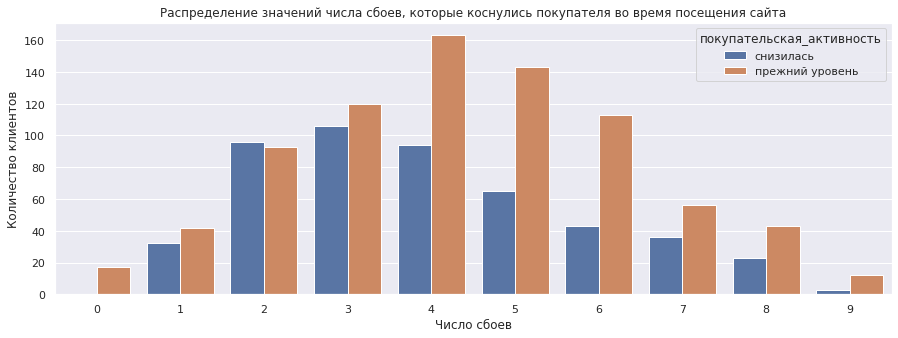

In [48]:
countplot_creator(market_main, 'ошибка_сервиса', 'Распределение значений числа сбоев, которые коснулись покупателя во время посещения сайта', 'Количество клиентов', 'Число сбоев')

Наблюдаем нормальное распределение. <font color='green'> Пользователи со снизившейся активностью реже сталкиваются с высокими значениями сбоев. Вероятно в силу того, что они в целом меньше взаимодействуют с сайтом.</font>

**Cреднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца (страниц за визит)**

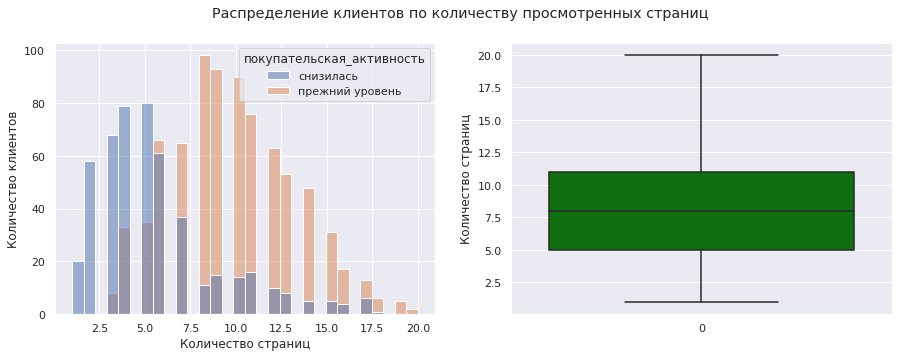

In [49]:
hist_und_box(market_main, 'страниц_за_визит', 'Количество страниц', 'Распределение клиентов по количеству просмотренных страниц')

Наблюдаем нормальное распределение со смещением влево. <font color='green'>Как и предполагалось, пользователи со снизившейся активностью просматривают меньше страниц.</font>

Изучим распределение категориальных признаков.

In [50]:
# Взглянем на сводную статистику по категориальным прзнакам.
market_main.describe(include='object').T

,count,unique,top,freq
покупательская_активность,1300,2,прежний уровень,802
тип_сервиса,1300,2,стандарт,924
разрешить_сообщать,1300,2,да,962
популярная_категория,1300,6,товары для детей,330
market_active_mean_cat,1300,3,3—5,862
market_active_last_cat,1300,3,Четыре,669
promotional_purchases_cat,1300,2,регулярный покупатель,1133
unpaid_products_cat,1300,7,один,261


Судя по сводной статистике, уже можно сказать, что в данных наблюдается дисбаланс классов. Визуализируем распределение значений.

**Рассчитанный класс покупательской активности (покупательская_активность):**

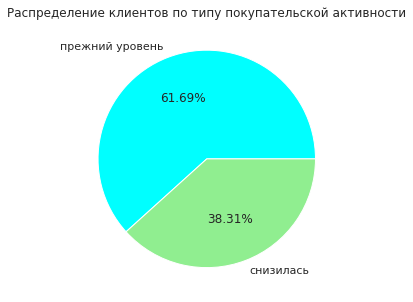

In [51]:
pieplot_creator(market_main, 'покупательская_активность', 'Распределение клиентов по типу покупательской активности')

**тип_сервиса:**

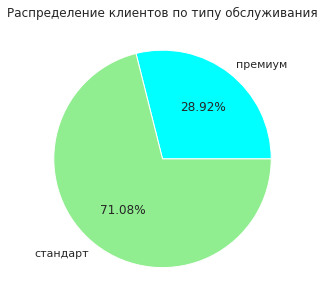

In [52]:
pieplot_creator(market_main, 'тип_сервиса', 'Распределение клиентов по типу обслуживания')

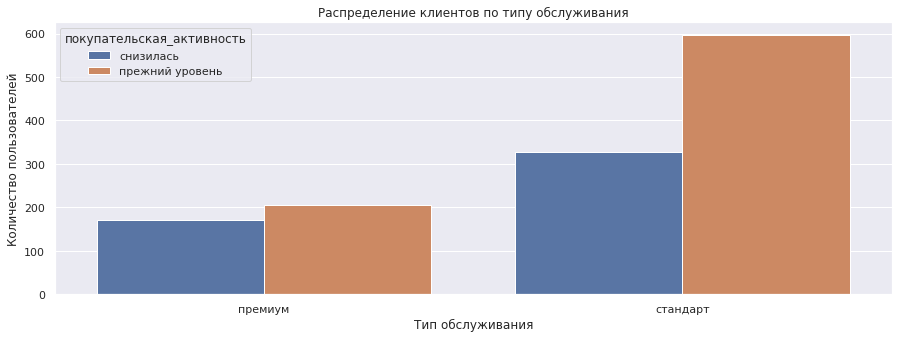

In [53]:
countplot_creator(market_main, 'тип_сервиса', 'Распределение клиентов по типу обслуживания', 'Количество пользователей', 'Тип обслуживания')

<font color='green'>Среди пользователей со снизившейся активностью доля пользователей с обслуживанием "Премиум" почти такая же как у пользователей со стандартным обслуживанием. Кажется, условия обслуживания "Премиум" не столь эфективно поддерживают активность, как моно было бы ожидать. </font>

**Можно ли присылать покупателю дополнительные предложения о товаре (разрешить_сообщать):**

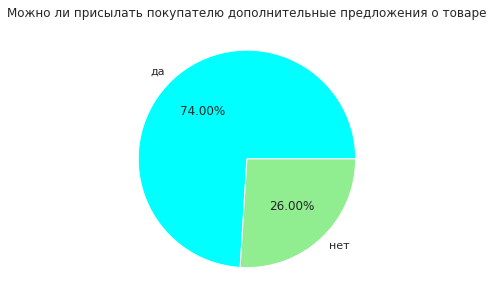

In [54]:
pieplot_creator(market_main, 'разрешить_сообщать', 'Можно ли присылать покупателю дополнительные предложения о товаре')

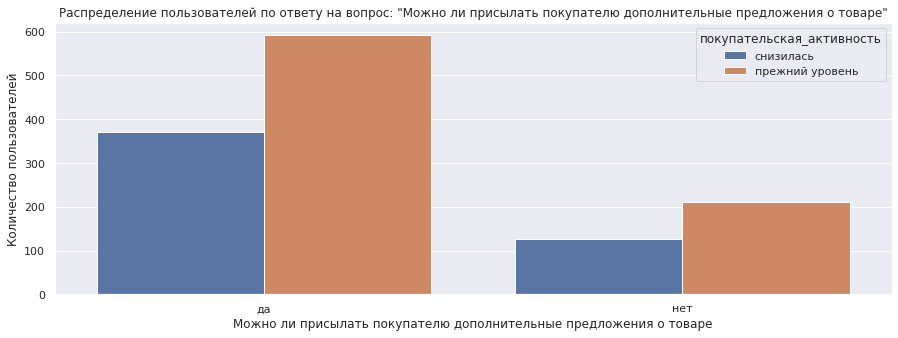

In [55]:
countplot_creator(market_main, 'разрешить_сообщать', 'Распределение пользователей по ответу на вопрос: "Можно ли присылать покупателю дополнительные предложения о товаре"', 'Количество пользователей', 'Можно ли присылать покупателю дополнительные предложения о товаре')

<font color='green'> Пользователи чаще соглашаются принимать дополнительные предложения. Для интересующей нас категории покупателей это так же характерно.</font>

**Самая популярная категория товаров у покупателя за последние 6 месяцев (популярная_категория):**

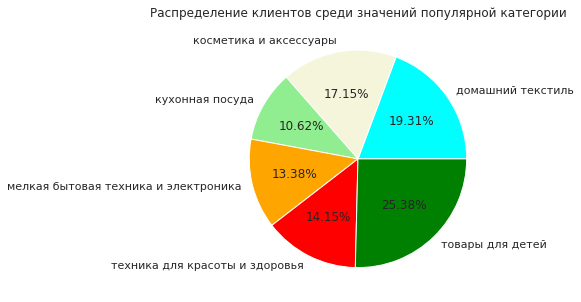

In [56]:
df_var = market_main.groupby('популярная_категория')['id'].count()
    
plt.pie(df_var, labels=df_var.index, colors=("cyan", "beige", "lightgreen", "orange", "red", "green"), autopct='%1.2f%%')
plt.title('Распределение клиентов среди значений популярной категории')
plt.show()

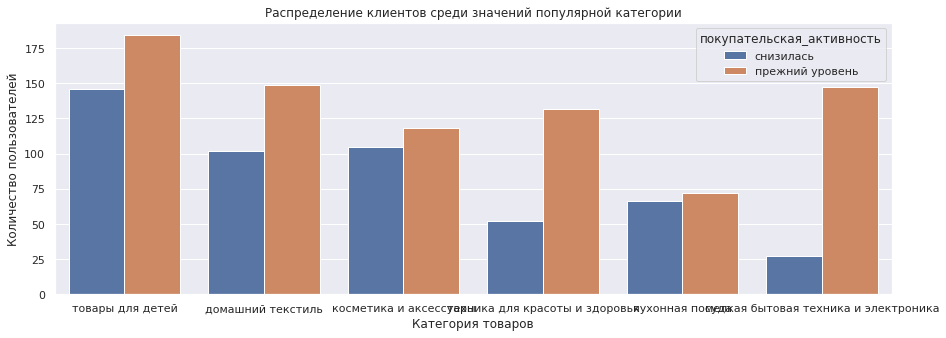

In [57]:
countplot_creator(market_main, 'популярная_категория', 'Распределение клиентов среди значений популярной категории', 'Количество пользователей', 'Категория товаров')

<font color='green'>Доля пользователей со снизившейся активностью заметно ниже только среди категорий бытовой теники и техники для красоты и здоровья. Возможно, товары из остальных категории чаще оказываются в центре маркетинговых компаний или в специальных предложениях для пользователей.</font>

**Промежуточный вывод:**

**Количественные признаки:**
- **маркет_актив_6_мес**: значения от 0.9 до 6.6. Значения менее, чем примерно 2.4, воспринимаются ящиком с усами как статистические выбросы. Для решеня проблем с выбросами решено ввести новый категориальный признак.<font color='green'> Отметим, что значения от 1 до 3 принадлежат пользователям в большей части со снизившейся активностью. Это могут быть пользователи, которые в целом редко посещают сайт. </font>
- **маркет_актив_тек_мес**: значения от 3 до 5. Значения 3 и 5 воспринимаются как выбросы, для решения проблемы введён категориальный признак.
- **длительность**: распределение значений: 110—1079 дней. Распределение близко к нормальному.
- **акционные_покупки**: значения от 0 до 0.99. На гистограмме наблюдаем два пика. Можно разделить покупателей на две группы: обычные клиенты и те, кто почти всегда берёт товары только по акции. <font color='green'>Причём высокая доля акционных покупок больше характерна для пользователей со снизившейся активностью. Можно сказать, что у интересующей нас категории покупателей вероятнее снижается активность после завершения акций. Вероятно некоторые категории клиентов получали специальные предложения, иначе бы график был бы более близок к нрмальному распределению.</font>
- **средний_просмотр_категорий_за_визит**: Значения от 1-го до 6-ти. Распределение на гистограмме похоже на нормальное, смещено влево. <font color='green'> Пользователи со снизившейся активностью в среднем просматривают меньше категорий. В целом уже можно предположить, что низкая активность на сайте более характерна для интересующей нас категории покупателей.</font>
- **неоплаченные_продукты_штук_квартал**: Значения от 0 до 10-ти. Значения больше 8-ми являются статистическими выбросами. <font color='green'> Значения больше пяти более характерныны для пользователей со снизившейся активностью.</font>
- **ошибка_сервиса**: Значения от 0 до 9-ти. Наблюдаем нормальное распределение. <font color='green'> Пользователи со снизившейся активностью реже сталкиваются с высокими значениями сбоев. Вероятно в силу того, что они в целом меньше взаимодействуют с сайтом.</font>
- **страниц_за_визит**: Значения от 1-ой до 20-ти страниц. Наблюдаем нормальное распределение со смещением влево. Выбросы отсутствуют. <font color='green'>Как и предполагалось, пользователи со снизившейся активностью просматривают меньше страниц.</font>

На основе изученных количественных признаков в датафрейм введены следующие категориальные признаки:
- **market_active_mean_cat**: на основе данных признака **маркет_актив_6_мес** введены категориальные значения со следующим распределением: меньше 3 — 9.92%, 3—5 — 66.31%, больше 5 — 23.77%.
- **market_active_last_cat**: на основе данных признака **маркет_актив_тек_мес** введены категориальные значения со следующим распределением: три — 23.69%, четыре — 51.46%, пять — 24.85%.
- **promotional_purchases_cat**: на основе данных признака **акционные_покупки** введены категориальные значения со следующим распределением: регулярный покупатель — 87.15%, акционный покупатель — 12.85%.
- **unpaid_products_cat**: на основе данных признака **неоплаченные_продукты_штук_квартал** введены категориальные значения со следующим распределением: не было неоплаченных товаров — 8.92%, один — 20.08%, два — 20.08%, три — 16.77%, четыре — 15.15%, пять — 10.38%, больше пяти — 8.62%.

**Категориальные признаки:**
- **покупательская_активность**: прежний уровень — 61.69% клиентов, снизилась — 38.31%.
- **тип_сервиса**: стандарт — 71.08% клиентов, премиум — 28.92%. <font color='green'>Среди пользователей со снизившейся активностью доля пользователей с обслуживанием "Премиум" почти такая же как у пользователей со стандартным обслуживанием. Кажется, условия обслуживания "Премиум" не столь эфективно поддерживают активность, как моно было бы ожидать. </font>
- **разрешить_сообщать**: да — 74% клиентов, нет — 26%. <font color='green'> Пользователи чаще соглашаются принимать дополнительные предложения. Для интересующей нас категории покупателей это так же характерно.</font>
- **популярная_категория**: товары для детей — 25.38% клиентов, домашний текстиль — 19.31%, косметика и аксессуары — 17.15%, техника для красоты и здоровья — 14.15%, мелкая бытовая техника и электроника — 13.38%, кухонная посуда — 10.62%. <font color='green'>Доля пользователей со снизившейся активностью заметно ниже только среди категорий бытовой теники и техники для красоты и здоровья. Возможно, товары из остальных категории чаще оказываются в центре маркетинговых компаний или в специальных предложениях для пользователей.</font>

[Назад к содержанию](#0)

<a id="4"><a/>
### Объединение таблиц

Теперь нужно объединим данные в один датафрейм. Для корректного объединения значения периода в таблицах **market_money** и **market_time** сперва сделаем новыми признаками.

In [58]:
# Преобразуем значения периода в датафрейме market_money в признаки и дадим им более актуальные названия.
market_euro = market_money.pivot(index='id', columns='период', values='выручка')
market_euro.columns = ['money_before_last_month', 'money_last_month', 'money_current_month']

# То же самое сделаем с датафреймом market_time.
market_min = market_time.pivot(index='id', columns='период', values='минут')
market_min.columns = ['time_last_month', 'time_current_month']

In [59]:
# Объединим данные в один датасет market.
market = market_main.merge(market_euro, how='left', on='id')
market = market.merge(market_min, how='left', on='id')
market.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,страниц_за_визит,market_active_mean_cat,market_active_last_cat,promotional_purchases_cat,unpaid_products_cat,money_before_last_month,money_last_month,money_current_month,time_last_month,time_current_month
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,...,5,3—5,Пять,регулярный покупатель,два,0.0,0.0,3293.1,13,14
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,...,5,3—5,Четыре,акционный покупатель,четыре,4472.0,5216.0,4971.6,12,10
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,...,5,3—5,Три,регулярный покупатель,два,4826.0,5457.5,5058.4,8,13
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,...,4,3—5,Пять,акционный покупатель,не было неоплаченных товаров,4793.0,6158.0,6610.4,11,13
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,...,2,5 или больше,Три,акционный покупатель,два,4594.0,5807.5,5872.5,8,11


In [60]:
# Проверим корректность данных.
market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

Данные объединены в одну таблицу. Пропусков при объединении не появилось, типы данных корректны.

[Назад к содержанию](#0)

<a id="3.2"><a/>
### Анализ данных market_money

Изучим сводную статистику датафрейма **market_money**.

In [61]:
# Статистика количественного признака.
market_money.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


In [62]:
# Статистика категориального признака.
market_money.describe(include='object').T

,count,unique,top,freq
период,3900,3,предпредыдущий месяц,1300


Судя по сводной статистике, значения периода разделены на три равные части, поэтому визуализируем только количественный признак.

**Сумма выручки за период (выручка):**

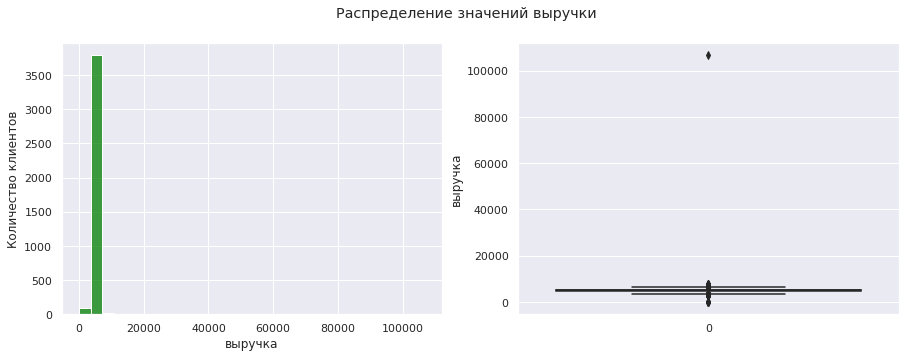

In [63]:
hist_und_box_boring(market_money, 'выручка', 'выручка', 'Распределение значений выручки')

Как и предполагалось, значение в 106862.2 сильно выбивается из остальных значений выборки. Значение вполне возможное, но на качество будущей модели повлияет не лучшим образом. Можно пожертвовать строкой с выбросом, но тогда при объединении данных в одну таблицу получим пропущенное значение, которое пока неочевидно каким образом можно будет адекватно заполнить. Возможно, пожертвовать данными одного пользователя будет более удачным решением.

In [64]:
# Вычислим id пользователя.
market_money.query('выручка > 100000')

,id,период,выручка
98,215380,текущий месяц,106862.2


In [65]:
# Удалим строки с данными пользователя 215380.
#market_main = market_main[~(market_main['id'] == 215380)]
market_money = market_money[~(market_money['id'] == 215380)]
#market_time = market_time[~(market_time['id'] == 215380)]
market = market[~(market['id'] == 215380)]
money_mean_month = money_mean_month[~(money_mean_month['id'] == 215380)]

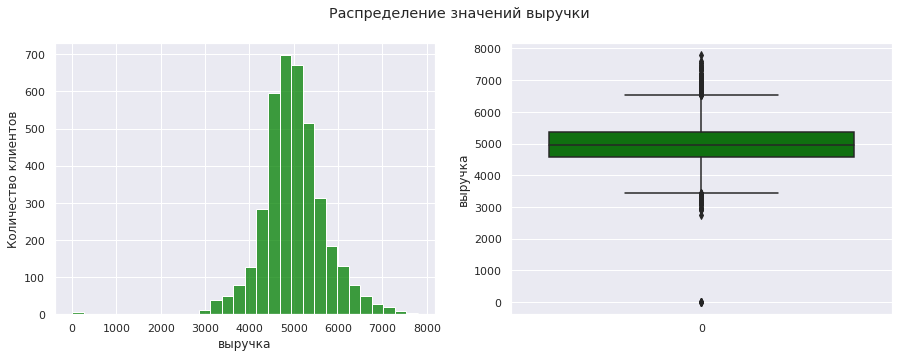

In [66]:
hist_und_box_boring(market_money, 'выручка', 'выручка', 'Распределение значений выручки')

Всё ещё наблюдаем множество выбросов, в том числе несколько нулевых значений. Пользователей, которые ничего не покупали в какой-то из месяцев, мы не можем назвать достаточно активными для нашей задачи. В дальнейшем их тоже нужно будет убрать  из всех таблиц.

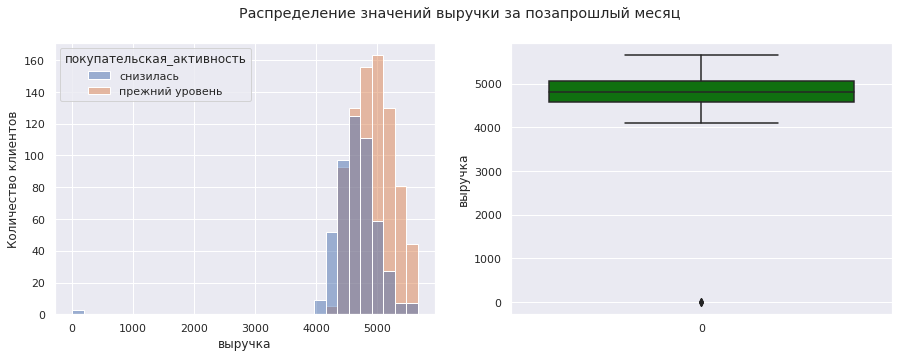

In [67]:
hist_und_box(market, 'money_before_last_month', 'выручка', 'Распределение значений выручки за позапрошлый месяц')

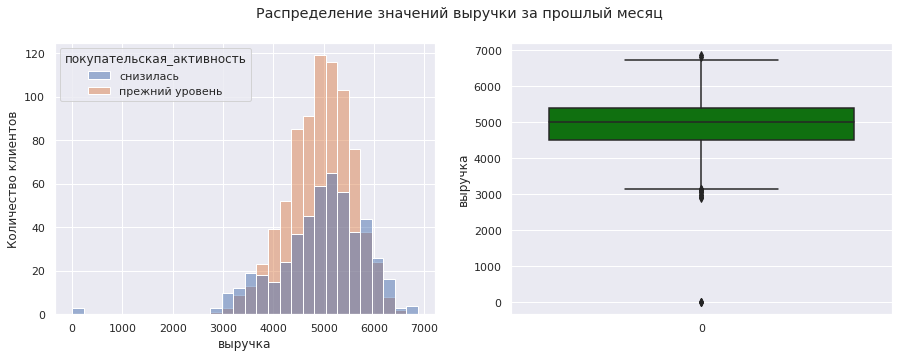

In [68]:
hist_und_box(market, 'money_last_month', 'выручка', 'Распределение значений выручки за прошлый месяц')

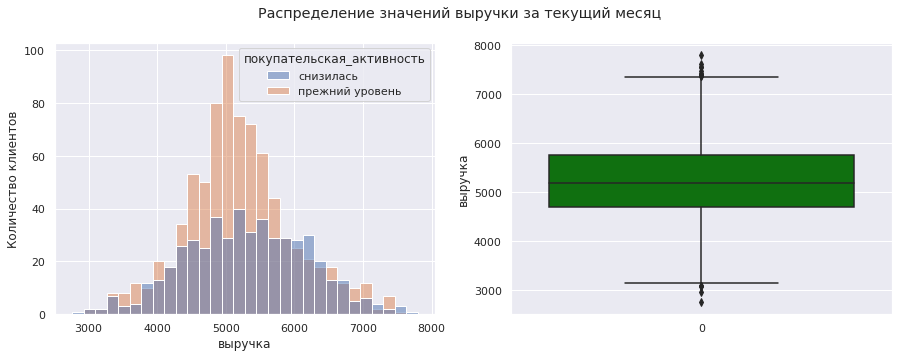

In [69]:
hist_und_box(market, 'money_current_month', 'выручка', 'Распределение значений выручки за текущий месяц')

<font color='green'>В позапрошлом месяце средняя выручка от пользователей со снизившейся активностью была заметно ниже, чем у активных. Начиная с прошлого месяца значения примерно выравнялись, да и в целом пользователи стали тратить больше. Возможно в прошлом месяце началась какая-то маркетинговая кампания.</font>

**Итоги**:

- Обнаружили у пользователя 215380 сильный выброс в значениях выручки. Данные данного пользователя убрали из всех таблиц.
- <font color='green'>В позапрошлом месяце средняя выручка от пользователей со снизившейся активностью была заметно ниже, чем у активных. Начиная с прошлого месяца значения примерно выравнялись, да и в целом пользователи стали тратить больше. Возможно в прошлом месяце началась какая-то маркетинговая кампания.</font>

<div class="alert alert-success">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>

👍 Отлично. В любом случае произошло некоторое изменение, которое мы видим из данных. 

[Назад к содержанию](#0)

<a id="3.3"><a/>
### Анализ данных market_time

In [70]:
market_time.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


In [71]:
market_time.describe(include='object').T

,count,unique,top,freq
период,2600,2,текущий месяц,1300


Похоже, значения периода разбиты на две равные части, поэтому визуализируем только распределение клиентов по значениям времени, проведённого на сайте.

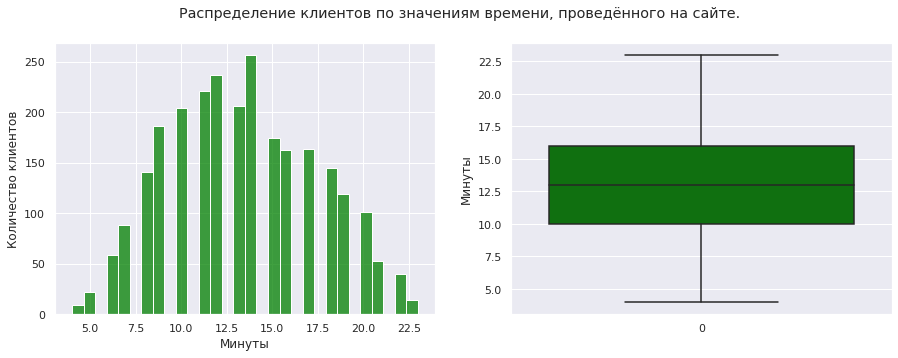

In [72]:
hist_und_box_boring(market_time, 'минут', 'Минуты', 'Распределение клиентов по значениям времени, проведённого на сайте.')

Наблюдаем нормальное распределение.

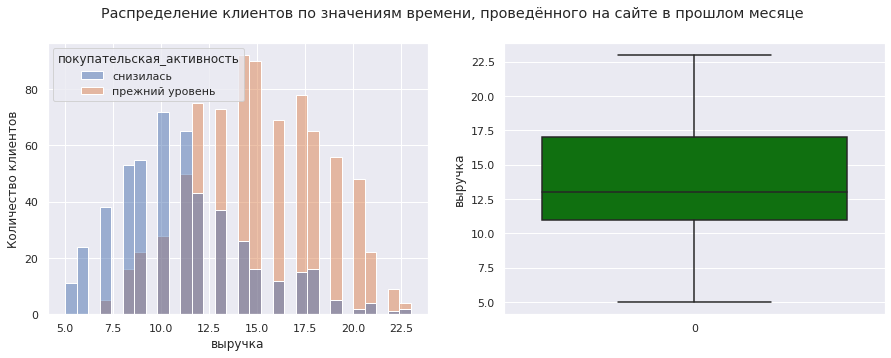

In [73]:
hist_und_box(market, 'time_last_month', 'выручка', 'Распределение клиентов по значениям времени, проведённого на сайте в прошлом месяце')

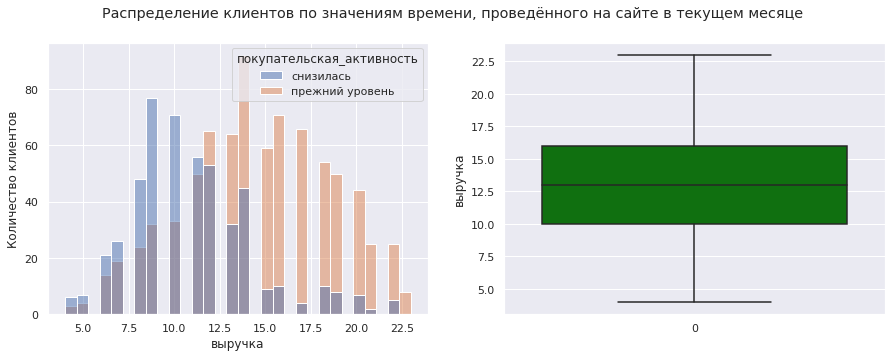

In [74]:
hist_und_box(market, 'time_current_month', 'выручка', 'Распределение клиентов по значениям времени, проведённого на сайте в текущем месяце')

<font color='green'>Пользователи со снизившейся активностью чаще проводят на сайте меньше времени.</font>

**Промежуточный вывод:**

- **минут**: распределение значений от 4-х до 23-х. На гистограмме наблюдаем нормальное распределене, выбросы отсутствуют.
- **период**: два значения "текущий месяц" и "предыдущий месяц" равно распределены: по 1300 значений.
- <font color='green'>Пользователи со снизившейся активностью чаще проводят на сайте меньше времени.</font>

[Назад к содержанию](#0)

<a id="3.4"><a/>
### Анализ данных money_mean_month

In [75]:
money_mean_month.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1299.0,215997.975366,375.174972,215348.00,215673.5,215998.00,216322.50,216647.00
прибыль,1299.0,3.996721,1.014107,0.86,3.3,4.05,4.67,7.43


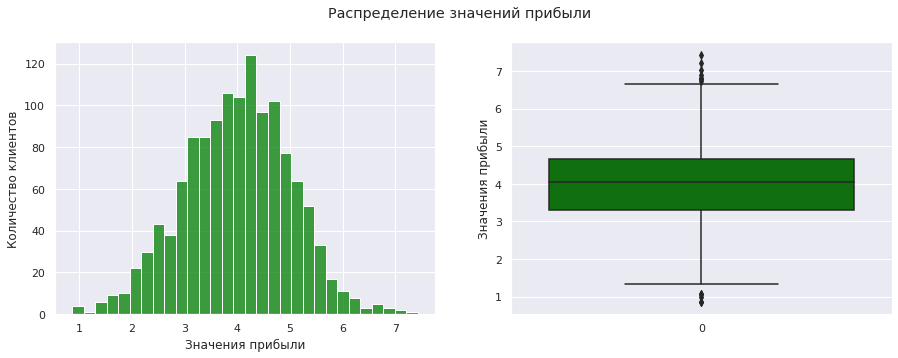

In [76]:
hist_und_box_boring(money_mean_month, 'прибыль', 'Значения прибыли', 'Распределение значений прибыли')

Значения прибыли от 0.86 до 7.43. Наблюдаем нормальное распределение.

[Назад к содержанию](#0)

<a id="3.5"><a/>
### Отбор активных клиентов

Отсеем пользователей, которые не совершали покупок регулярно на протяжении последних трёх месяцев.

In [77]:
# Найдём пользовтелей, которые не покупали ничего хотя бы в один из трёх месяцев.
market_money.groupby('id').prod().query('выручка == 0')

,выручка
id,
215348,0.0
215357,0.0
215359,0.0


Выявили id недостаточно активных покупателей. На их основе удалим строки с данными этих пользователей во всех наборах данных.

In [78]:
# Создадим функцию, которая удалит строки с id недостаточно активных пользователей.
def inactive_filter(df):
    inactive_id =  [215348, 215357, 215359]
    for i in inactive_id:
        df = df[~(df['id'] == i)]
    return df

# Применим функцию ко всем датафеймам.
#market_main = inactive_filter(market_main)
#market_money = inactive_filter(market_money)
market = inactive_filter(market)
money_mean_month = inactive_filter(money_mean_month)

<font color='green'>
<b>По итогу анализа можно составить следующий портрет пользователя со снизившейся активностью:</b>
    
- В целом меньше взаимодействий с сайтом: в среднем около 10-12 минут в месяц, просматривают меньше категорий за визит, меньше страниц.
- Чаще совершают покупки по акции.
- Чаще имеют в корзине больше пяти неоплаченных товаров за квартал.
- Чаще заинтересованы в следующих категориях товаров: товары для детей, косметика и аксессуары, домашний текстиль, кухонная посуда.
- Обладают типом обслуживания "Премиум" почти так же часто, как и стандартные пользователи.

</font>

[Назад к содержанию](#0)

<a id="5"><a/>
## Корреляционный анализ

Начнём корреляционный анализ с изучения матрицы корреляции.

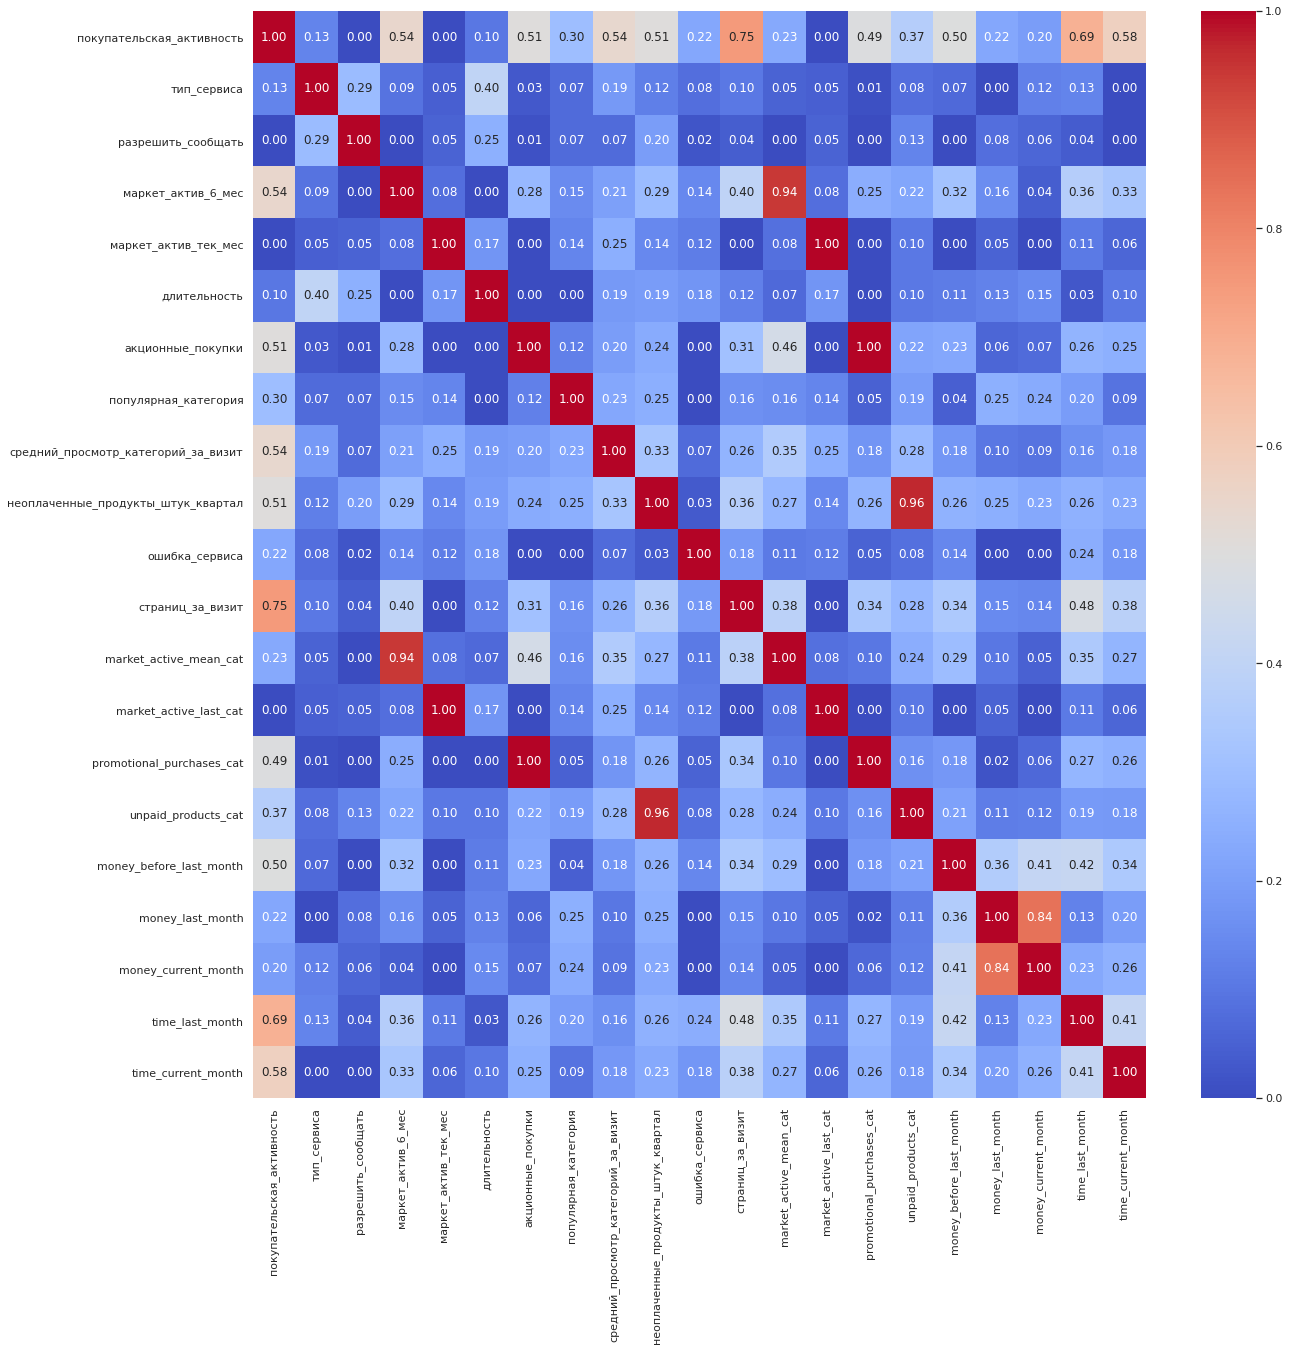

In [82]:
plt.figure(figsize=(20, 20))
sns.heatmap(market.drop('id', axis=1).phik_matrix(interval_cols=['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'money_before_last_month', 'money_last_month', 'money_current_month', 'time_last_month', 'time_current_month']), annot=True, cmap='coolwarm', fmt='.2f');

Целевым признаком при моделировании для нас будет признак **покупательская_активность**. Изучим корреляцию признаков датафрейма **market** с целевым:

- **тип_сервиса**: 0.13 — слабая теснота связи.
- **разрешить_сообщать**: Не наблюдаем связи с целевым признаком.
- **маркет_актив_6_мес**: 0.54 — умеренная связь.
- **маркет_актив_тек_мес**: Не наблюдаем связи с целевым признаком.
- **длительность**: 0.10 — слабая теснота связи.
- **акционные_покупки**: 0.51 — наблюдаем заметную связь.
- **популярная_категория**: 0.30 — слабая теснота связи.
- **средний_просмотр_категорий_за_визит**: 0.54 — наблюдаем заметную связь.
- **неоплаченные_продукты_штук_квартал**: 0.51 — наблюдаем умеренную связь.
- **ошибка_сервиса**: 0.22 — слабая теснота связи.
- **страниц_за_визит**: 0.75 — наблюдаем высокую корреляцию.
- **money_before_last_month**: 0.50 — наблюдаем умеренную связь.
- **money_last_month**: 0.22 — слабая теснота связи.
- **money_current_month**: 0.20 — слабая теснота связи.
- **time_last_month**: 0.69 — признак заметно коррелирует с целевым.
- **time_current_month**: 0.58 — признак заметно коррелирует с целевым.
- **market_active_mean_cat**: 0.23 — слабая теснота связи.
- **market_active_last_cat**: Как и в случае с количественным признаком связи не наблюдаем.
- **promotional_purchases_cat**: 0.49 — наблюдаем умеренную связь с целевым признаком.
- **unpaid_products_cat**: 0.37 — наблюдаем умеренную связь.

In [83]:
market = market.drop(['market_active_mean_cat', 'market_active_last_cat', 'promotional_purchases_cat', 'unpaid_products_cat'], axis=1)

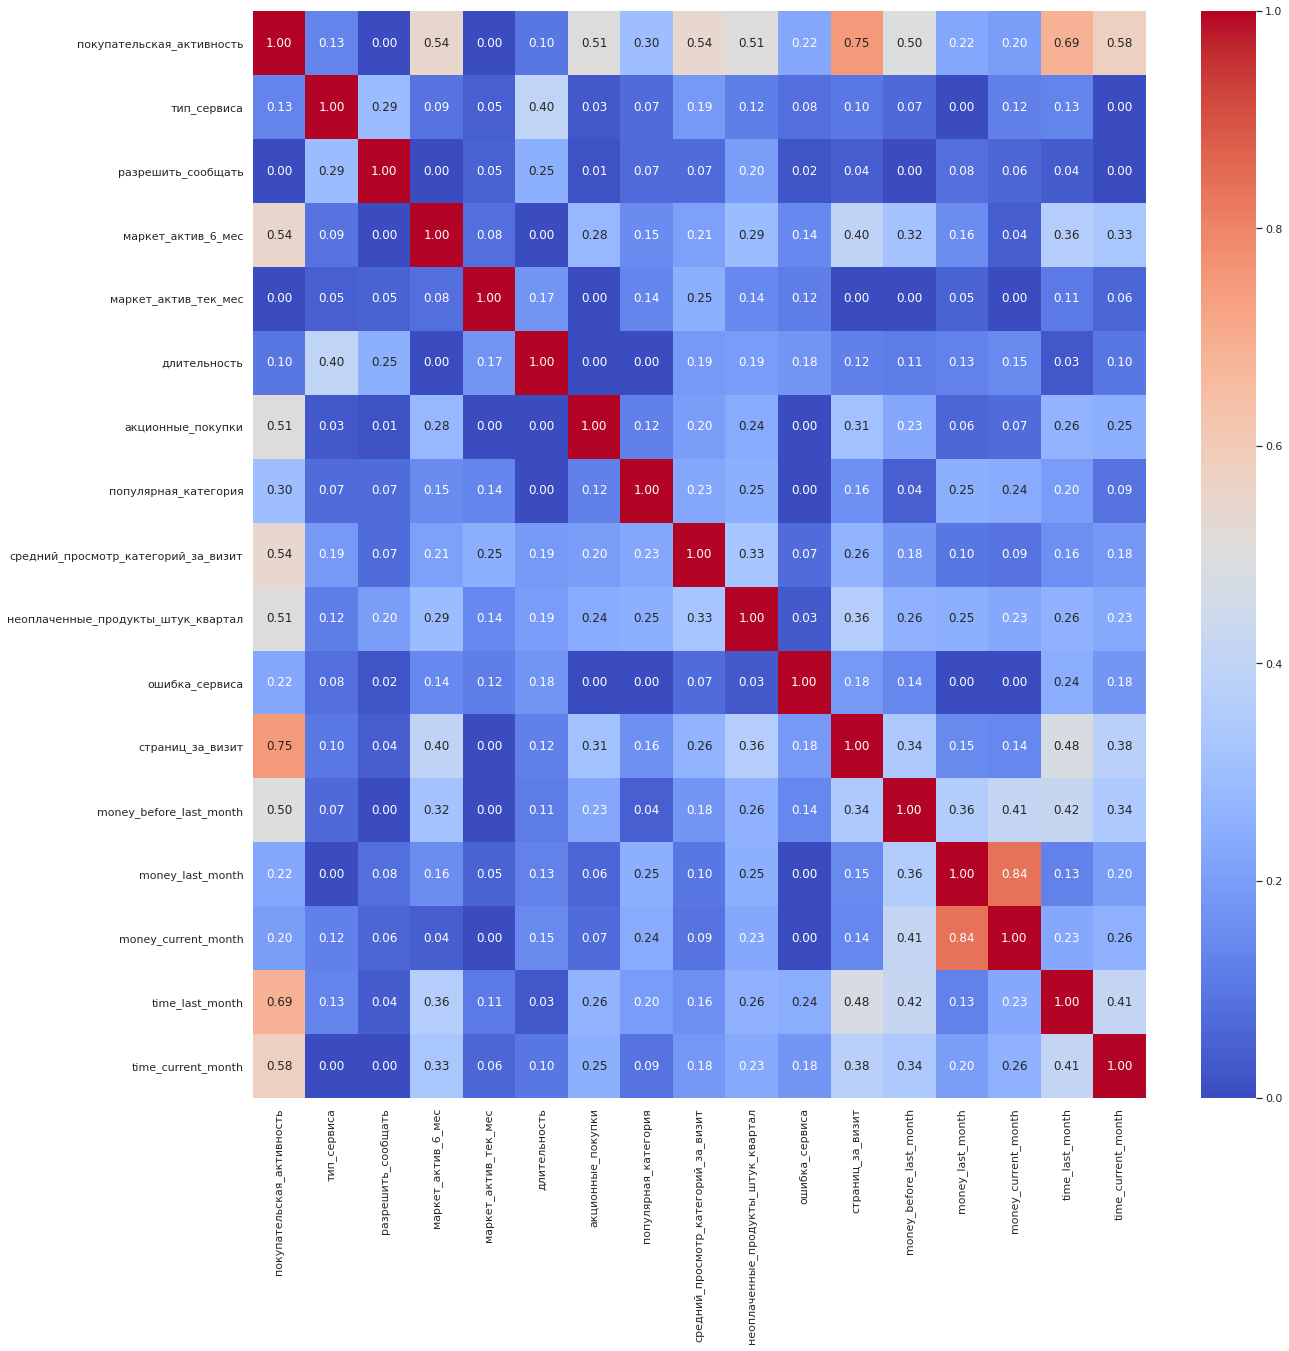

In [84]:
# Взглянем на обновлённую матрицу корреляции.
plt.figure(figsize=(20, 20))
sns.heatmap(market.drop('id', axis=1).phik_matrix(
    interval_cols=[
        'маркет_актив_6_мес', 
        'маркет_актив_тек_мес',
        'длительность', 
        'акционные_покупки', 
        'средний_просмотр_категорий_за_визит', 
        'неоплаченные_продукты_штук_квартал', 
        'ошибка_сервиса', 'страниц_за_визит', 
        'money_before_last_month', 
        'money_last_month', 
        'money_current_month', 
        'time_last_month', 
        'time_current_month'
    ]
), annot=True, cmap='coolwarm', fmt='.2f');

**Итоги анализа:** Избавились от введённых прежде на этапе анализа данных категориальных признаков.

[Назад к содержанию](#0)

<a id="6"><a/>
## Использование пайплайнов

Можно приступать к обучению моделей. Нам нужно предсказать снизилась ли активность клиента или осталась на прежнем уровне, то есть выполнить задачу бинарной классификации. Для данной задачи нам подойдут следующие модели:
- Дерево решений (DecisionTreeClassifier())
- Метод К ближайших соседей (KNeighborsClassifier())
- Модель логистической регрессии (LogisticRegression())
- Модель классиффикации опорных векторов (SVC())

По результатам исследовательского анализа нам известно, что все категориальные признаки подвержены дисбалансу классов. Для решения проблемы при разделении данных параметру stratify передадим значение целевого признака, при инициализации класса для рандомизированного поиска гиперпараметров укажем параметр кросс-валидации.

In [85]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Разделяем данные на выборки.
X_train, X_test, y_train, y_test = train_test_split(
    market.drop(['id','покупательская_активность'], axis=1),
    market['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market['покупательская_активность'])

X_train.shape, X_test.shape

((972, 16), (324, 16))

In [86]:
# Выделим списки признаков под разные задачи кодирования и масштабирования.
ohe_columns = ['тип_сервиса', 'разрешить_сообщать']
ord_columns = ['популярная_категория']
num_columns = [
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес',
    'длительность', 
    'акционные_покупки', 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
    'money_before_last_month',
    'money_last_month',
    'time_last_month',
    'time_current_month'
]

In [87]:
# Создаём пайплайн с кодированием признаков OneHotEncoder.
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

In [88]:
# Создаём пайплайн с кодированием признаков OrdinalEncoder.
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', 
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simple_Imputer',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [89]:
# Объединим шаги по подготовке данных.
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

In [90]:
# Cоздаём итоговый пайплайн.
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

In [91]:
# Зададим гиперпараметры для моделей.
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'models__min_samples_leaf': range(1, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='saga', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['rbf', 'sigmoid', 'poly'],
        'models__degree': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [92]:
# Инициализируем класс для рандомизированного поиска гиперпараметров.
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of t

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['тип_сервиса',
                                                                                'разрешить_сообщать']),
                                                                              ('ord',
                                                                               Pipeline(steps=[...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='saga')],
                                         'models__C': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__degree': range(1, 6),
                                         'models__kernel': ['rbf', 'sigmoid',
                                                            'poly'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [93]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

y_test_pred = randomized_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                          

Итак, лучше всего себя показало дерево решений без масштабирования с 3-мя уровнями с правилами и 4-мя признаками.

**Промежуточный итог:**

На данном этапе был создан пайплайн для подбора модели с лучшей предсказательной способностью. Для оценки качества модели была использована метрика ROC-AUC, так как она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного. 

<font color='green'>
Лучше всех всех метрика качества у дерева решений с 3-мя уровнями с правилами и 4-мя признаками.</font>



<font color='green'>
    
Метрика лучшей модели на кросс-валидации: 0.8482418149554514

Метрика ROC-AUC на тестовой выборке: 0.8891315778829431</font>

[Назад к содержанию](#0)

<a id="7"><a/>
## Анализ важности признаков

Определили модель с лучшим результатом, теперь взглянем какие признаки она считает наиболее важными при создании предсказаний.

In [94]:
# Выделим интересующую нас модель.
best_pipe = randomized_search.best_estimator_.named_steps['models']

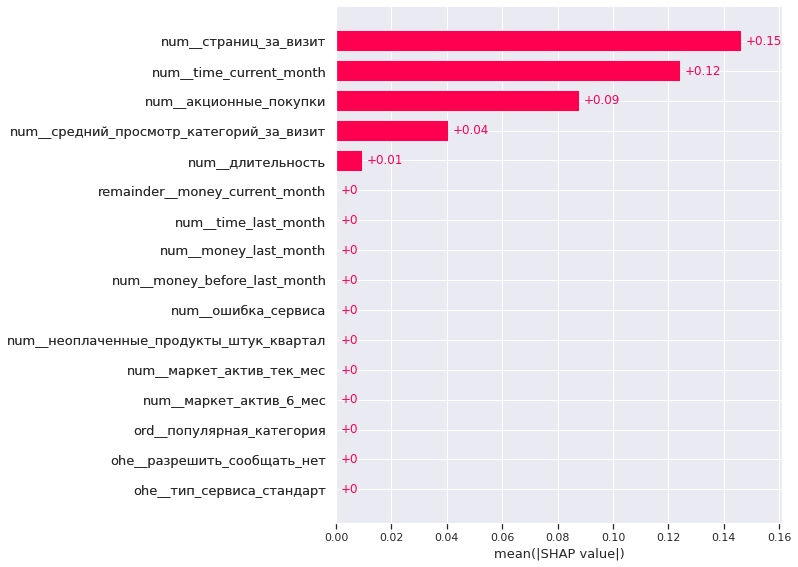

In [95]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)

X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

shap_values = explainer(X_test_2)

shap.plots.bar(shap_values[:, :, 0], max_display=22)

<font color='green'>
Итак, модель принимает решения на основе 4-ёх признаков:
    
- Количество страниц за визит: самый важный признак.
- Доля акционных покупок.
- Выручка за позапрошлый месяц.
- Среднее число маркетинговых коммуникаций за полгода.</font>

C помощью метода SHAP изучим влияние каждого признака на предсказания модели.

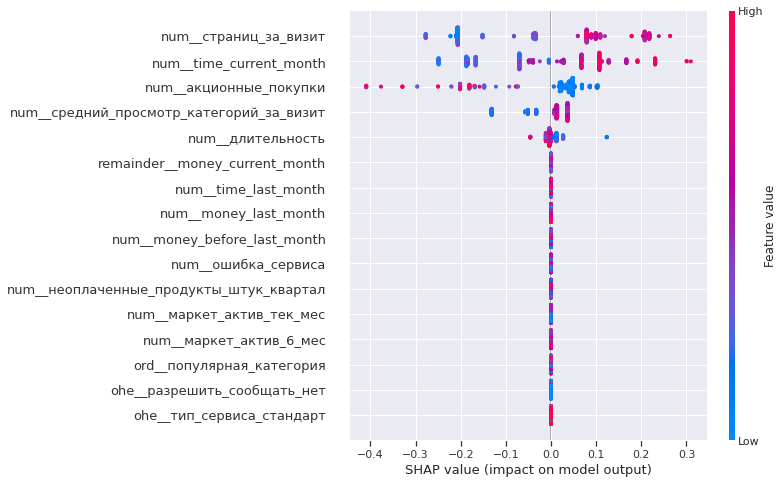

In [96]:
shap.plots.beeswarm(shap_values[:, :, 0], max_display=22)

<font color='green'>
Анализ важности признаков:

- **Количество страниц за визит**: малые значения увеличивают вероятность принадлежности к классу "снизилась".
- **Доля акционных покупок**: большие значения увеличивают вероятность принадлежности к классу "снизилась".
- **Выручка за позапрошлый месяц**: малые значения увеличивают вероятность принадлежности к классу "снизилась".
- **Среднее число маркетинговых коммуникаций за полгода**: большие значения увеличивают вероятность принадлежности к классу "снизилась".</font>

**Выводы**:

<font color='green'>
<b>Модель принимает решения на основе 4-ёх признаков:</b>
    
- Количество страниц за визит: самый важный признак.
- Доля акционных покупок.
- Выручка за позапрошлый месяц.
- Среднее число маркетинговых коммуникаций за полгода.

**Из анализа графика SHAP-значений отметим следующее:**

- **Количество страниц за визит**: малые значения увеличивают вероятность принадлежности к классу "снизилась".
- **Доля акционных покупок**: большие значения увеличивают вероятность принадлежности к классу "снизилась".
- **Выручка за позапрошлый месяц**: малые значения увеличивают вероятность принадлежности к классу "снизилась".
- **Среднее число маркетинговых коммуникаций за полгода**: большие значения увеличивают вероятность принадлежности к классу "снизилась".</font>

[Назад к содержанию](#0)

<a id="8"><a/>
## Сегментация покупателей

Вероятно, для бизнеса будет важнее поддерживать покупательскую активность клиентов, которые приносят наибольшую прибыль, соответственно для сегментации покупателей выделим клиентов с высокой вероятностью снижения активности и с высоким показателем среднемесячной прибыли.

In [100]:
# Создадим датафрейм с данными для предсказаний и введём признаки прибыли и вероятности снижения активности клиента.
market_segment = market.merge(money_mean_month, on='id')
market_segment['вероятность_снижения_активности'] = randomized_search.predict_proba(
    market_segment.drop(['прибыль', 'id', 'покупательская_активность'], axis=1)
)[:,1]
market_segment.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,money_before_last_month,money_last_month,money_current_month,time_last_month,time_current_month,прибыль,вероятность_снижения_активности
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,4.16,0.958580
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,3.13,0.092437
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,4.87,0.958580
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,4.21,0.958580
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,3.95,0.763359


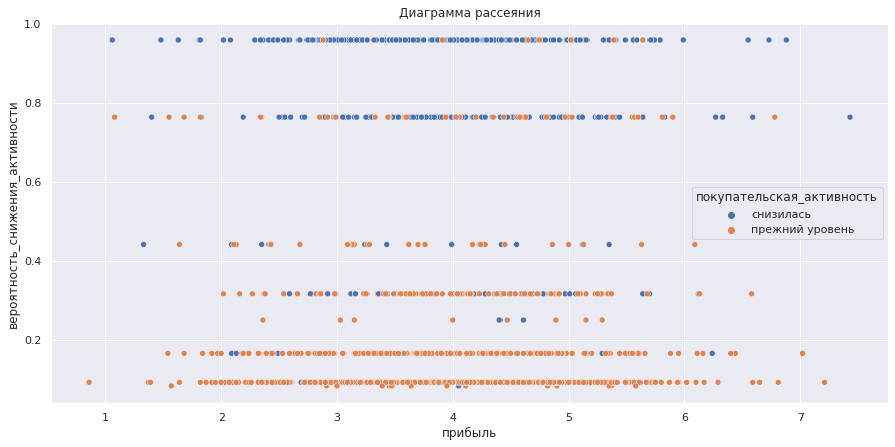

In [101]:
# Построим диаграмму рассеяния.
sns.set(rc={'figure.figsize': (15, 7)})
sns.scatterplot(data=market_segment, x='прибыль', y='вероятность_снижения_активности', hue='покупательская_активность')
plt.title('Диаграмма рассеяния')
plt.show()

Выделим пользователей с вероятностью снижения активности больше 0.80 и значением прибыли больше 3.

In [102]:
target_users = market_segment[(market_segment['вероятность_снижения_активности'] >= 0.80) & (market_segment['прибыль'] >= 3)]
non_targeted_users = market_segment[~(market_segment['вероятность_снижения_активности'] >= 0.80) & (market_segment['прибыль'] >= 3)]

# Проверим выборку на репрезентативность
target_users.shape

(193, 20)

In [103]:
def scatter_und_scatter(df_1, df_2, column_x, column_y, axes_name, title):
    sns.set(rc={'figure.figsize': (15, 7)})
    fig, axes = plt.subplots(1, 2)
    
    sns.scatterplot(data=df_1, x=column_x, y=column_y, color='green', ax=axes[0])
    axes[0].set(ylabel='Вероятность снижения активности', xlabel=axes_name)
    
    sns.scatterplot(data=df_2, x=column_x, y=column_y, color='green', ax=axes[1])
    axes[1].set(ylabel='Вероятность снижения активности', xlabel=axes_name)
    
    plt.suptitle(title)
    plt.show()

In [104]:
def hist_und_hist(df_1, df_2, column, axes_name, title):
    sns.set(rc={'figure.figsize': (15, 5)})
    fig, axes = plt.subplots(1, 2)
    
    sns.histplot(data=df_1, bins=30, x=column, ax=axes[0], color='blue')
    axes[0].set(ylabel='Количество клиентов', xlabel=axes_name)
    
    sns.histplot(data=df_2, bins=30, x=column, ax=axes[1], color='blue')
    axes[1].set(ylabel='Количество клиентов', xlabel=axes_name)
    
    plt.suptitle(title)
    plt.show()

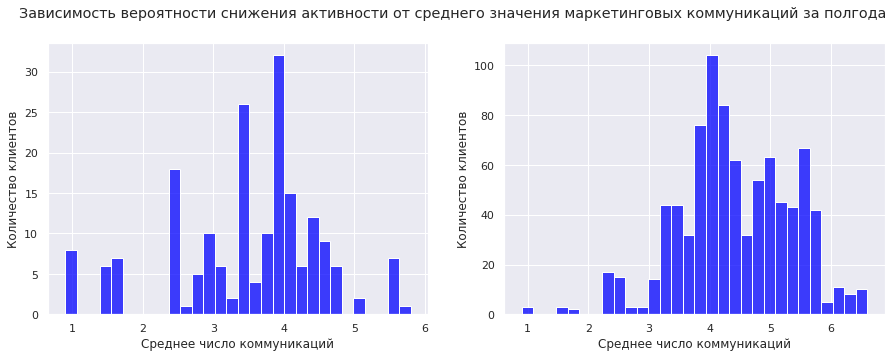

In [105]:
#scatter_und_scatter(target_users, non_targeted_users, 'маркет_актив_6_мес', 'вероятность_снижения_активности', 'Среднее число коммуникаций', 'Зависимость вероятности снижения активности от среднего значения маркетинговых коммуникаций за полгода')
hist_und_hist(target_users, non_targeted_users, 'маркет_актив_6_мес', 'Среднее число коммуникаций', 'Зависимость вероятности снижения активности от среднего значения маркетинговых коммуникаций за полгода')

<font color='green'> В среднем с целевым сегментом меньше коммуникаций, но если он в целом сходен с портретом целевого покупателя, то покупатели из целевого сегмента просто меньше проводят времени на сайте.
</font>

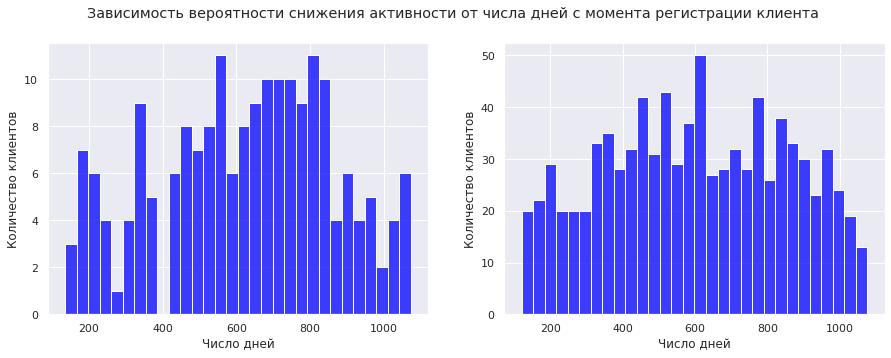

In [106]:
#scatter_und_scatter(target_users, non_targeted_users, 'длительность', 'вероятность_снижения_активности', 'Число дней', 'Зависимость вероятности снижения активности от числа дней с момента регистрации клиента')
hist_und_hist(target_users, non_targeted_users, 'длительность', 'Число дней', 'Зависимость вероятности снижения активности от числа дней с момента регистрации клиента')

Очень сходное распределение. 

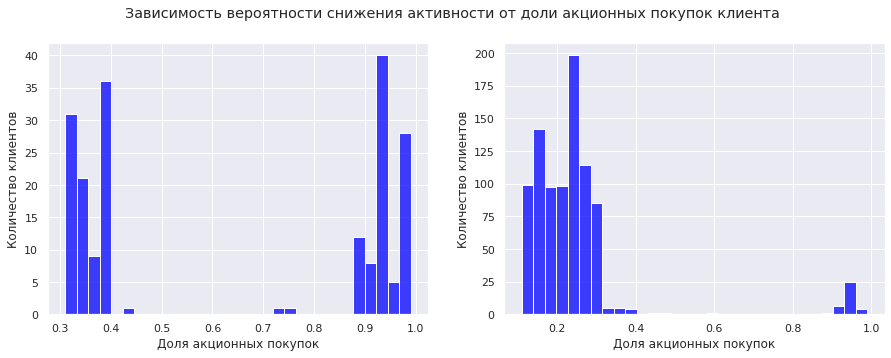

In [107]:
#scatter_und_scatter(target_users, non_targeted_users, 'акционные_покупки', 'вероятность_снижения_активности', 'Доля акционных покупок', 'Зависимость вероятности снижения активности от доли акционных покупок клиента')
hist_und_hist(target_users, non_targeted_users, 'акционные_покупки', 'Доля акционных покупок', 'Зависимость вероятности снижения активности от доли акционных покупок клиента')

<font color='green'>Целевой сегмент чаще составляют пользователи  с долей акционных покупок больше 0.3. Похоже, что целевой сегмент в этом сходен с общим портретом пользователей со снизившейся активностью. Если так, то мы должны увидеть рост средней выручки от сегмента от позапрошлого месяца к прошлому.</font>

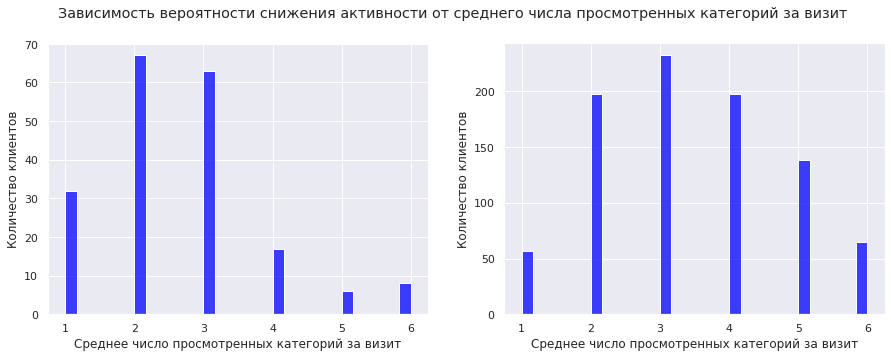

In [108]:
#scatter_und_scatter(target_users, non_targeted_users, 'средний_просмотр_категорий_за_визит', 'вероятность_снижения_активности', 'Среднее число просмотренных категорий за визит', 'Зависимость вероятности снижения активности от среднего числа просмотренных категорий за визит')
hist_und_hist(target_users, non_targeted_users, 'средний_просмотр_категорий_за_визит', 'Среднее число просмотренных категорий за визит', 'Зависимость вероятности снижения активности от среднего числа просмотренных категорий за визит')

Целевой сегмент реже просматривает больше трёх категорий. <font color='green'> Опять же объясняется это меньшей заинтересованностью в взаимодействии с сайтом.
</font>

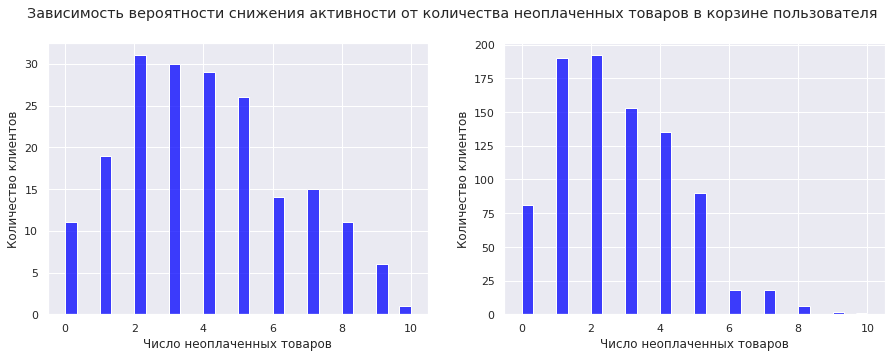

In [109]:
#scatter_und_scatter(target_users, non_targeted_users, 'неоплаченные_продукты_штук_квартал', 'вероятность_снижения_активности', 'Число неоплаченных товаров', 'Зависимость вероятности снижения активности от количества неоплаченных товаров в корзине пользователя')
hist_und_hist(target_users, non_targeted_users, 'неоплаченные_продукты_штук_квартал', 'Число неоплаченных товаров', 'Зависимость вероятности снижения активности от количества неоплаченных товаров в корзине пользователя')

Характер распределения, в целом, достаточно общий. <font color='green'> Есть сходство с общим портретом клиентов со снизившейся активностью: целевой сегмент чаще имеет значения больше пяти неоплаченных товаров в корзине.
</font>

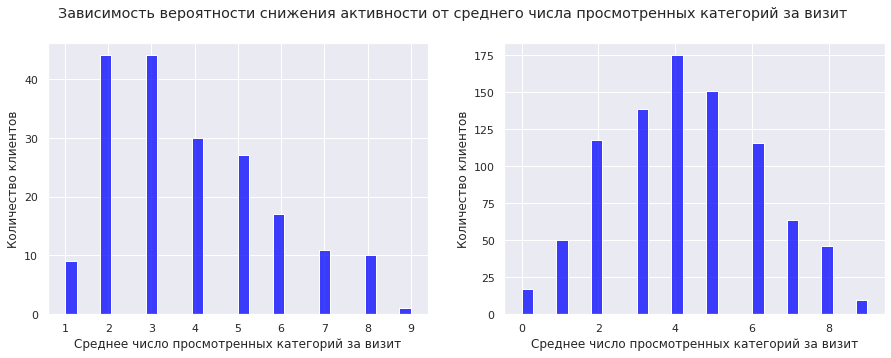

In [110]:
#scatter_und_scatterhist_und_hist
hist_und_hist(target_users, non_targeted_users, 'ошибка_сервиса', 'Среднее число просмотренных категорий за визит', 'Зависимость вероятности снижения активности от среднего числа просмотренных категорий за визит')

<font color='green'>Целевой сегмент проявляет меньше активности.</font>

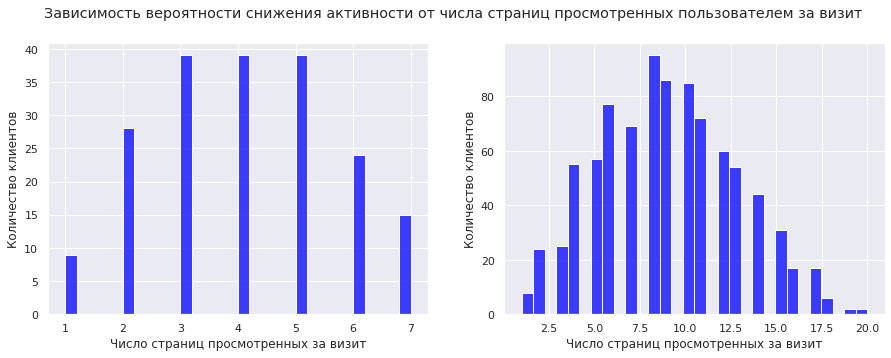

In [111]:
#scatter_und_scatter(target_users, non_targeted_users, 'страниц_за_визит', 'вероятность_снижения_активности', 'Число страниц просмотренных за визит', 'Зависимость вероятности снижения активности от числа страниц просмотренных пользователем за визит')
hist_und_hist(target_users, non_targeted_users, 'страниц_за_визит', 'Число страниц просмотренных за визит', 'Зависимость вероятности снижения активности от числа страниц просмотренных пользователем за визит')

<font color='green'>Целевой сегмент вообще не смотрит больше 7-ми страниц.</font>

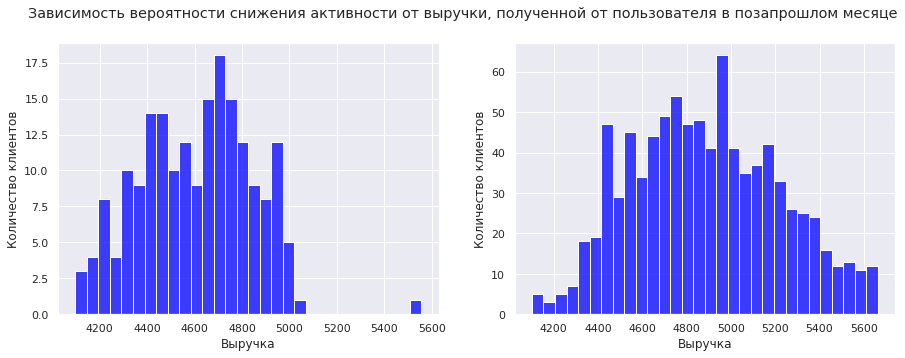

In [112]:
#scatter_und_scatter(target_users, non_targeted_users, 'money_before_last_month', 'вероятность_снижения_активности', 'Выручка', 'Зависимость вероятности снижения активности от выручки, полученной от пользователя в позапрошлом месяце')
hist_und_hist(target_users, non_targeted_users, 'money_before_last_month', 'Выручка', 'Зависимость вероятности снижения активности от выручки, полученной от пользователя в позапрошлом месяце')

Выручка за предпредыдущий месяц от целевого сегмента в среднем была ниже.

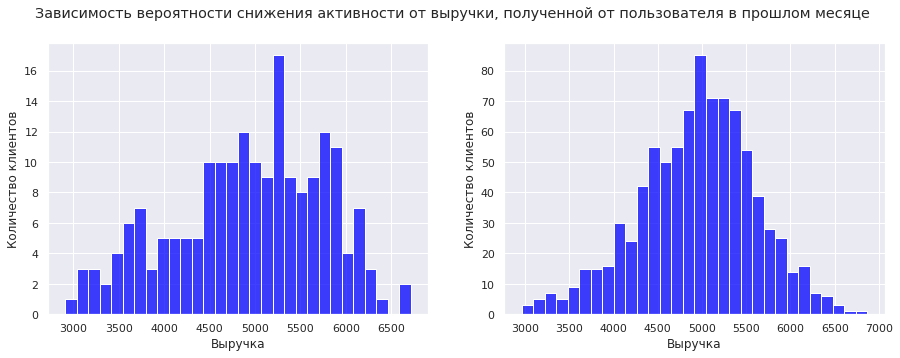

In [113]:
#scatter_und_scatter(target_users, non_targeted_users, 'money_last_month', 'вероятность_снижения_активности', 'Выручка', 'Зависимость вероятности снижения активности от выручки, полученной от пользователя в прошлом месяце')
hist_und_hist(target_users, non_targeted_users, 'money_last_month', 'Выручка', 'Зависимость вероятности снижения активности от выручки, полученной от пользователя в прошлом месяце')

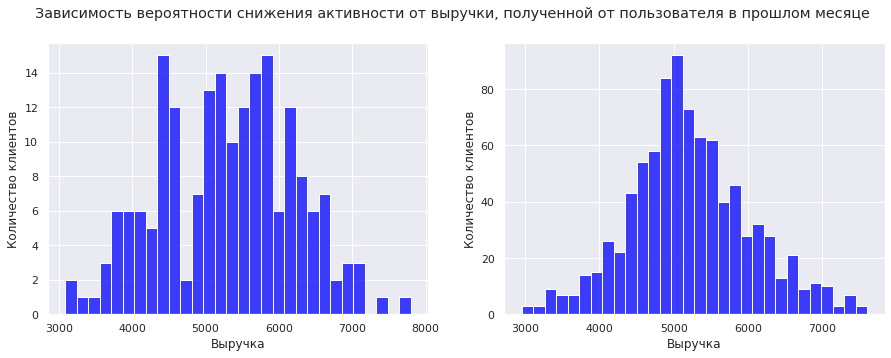

In [114]:
hist_und_hist(target_users, non_targeted_users, 'money_current_month', 'Выручка', 'Зависимость вероятности снижения активности от выручки, полученной от пользователя в прошлом месяце')

А вот за прошлый месяц и текущий распределение довольно похожее. Да и в целом значения выручки выше. Вероятно это результат какой-то маркетинговой кампании.  <font color='green'>Акции очевидно хороший способ поднять активность целевого сегмента.</font>

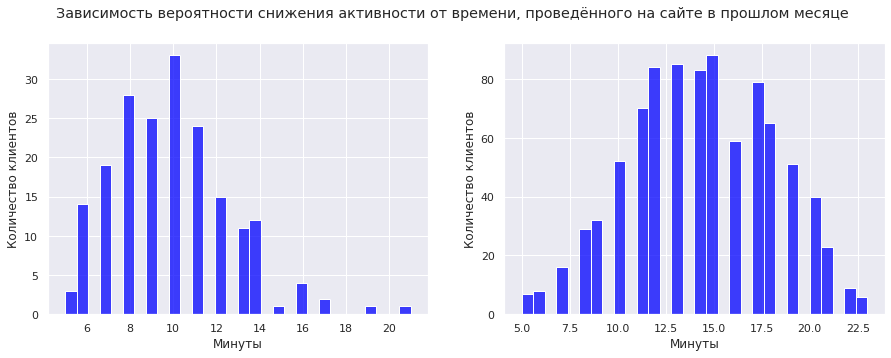

In [115]:
#scatter_und_scatter(target_users, non_targeted_users, 'time_last_month', 'вероятность_снижения_активности', 'Минуты', 'Зависимость вероятности снижения активности от времени, проведённого на сайте в прошлом месяце')
hist_und_hist(target_users, non_targeted_users, 'time_last_month', 'Минуты', 'Зависимость вероятности снижения активности от времени, проведённого на сайте в прошлом месяце')

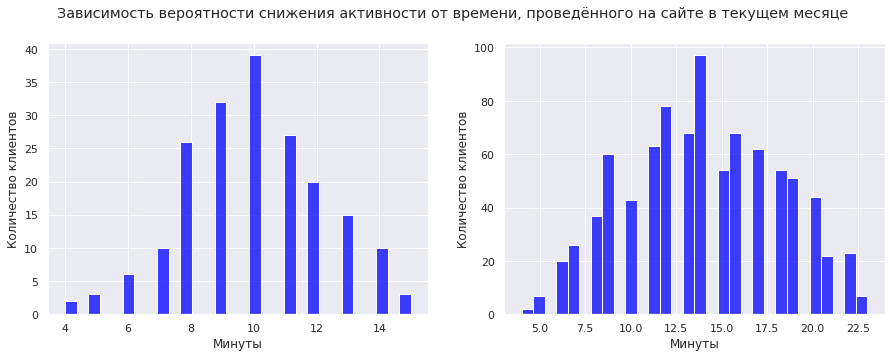

In [116]:
#scatter_und_scatter(target_users, non_targeted_users, 'time_current_month', 'вероятность_снижения_активности', 'Минуты', 'Зависимость вероятности снижения активности от времени, проведённого на сайте в текущем месяце')
hist_und_hist(target_users, non_targeted_users, 'time_current_month', 'Минуты', 'Зависимость вероятности снижения активности от времени, проведённого на сайте в текущем месяце')

Имеется общая тенденция: у целевого сегмента время взаимодействия с сайтом обычно не превышает 14-ти минут, в среднем целевой сегмент проводит на сайте меньше времени. <s>Возможно активность будет роще поддерживать, если сайт будет удерживать внимание пользователя подольше.</s>

In [122]:
def countplot_creator(df, column, title, ylabel, xlabel):
    sns.set_style('whitegrid')
    plt.figure(figsize=(15, 5))
    
    sns.countplot(data=df, x=column);
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

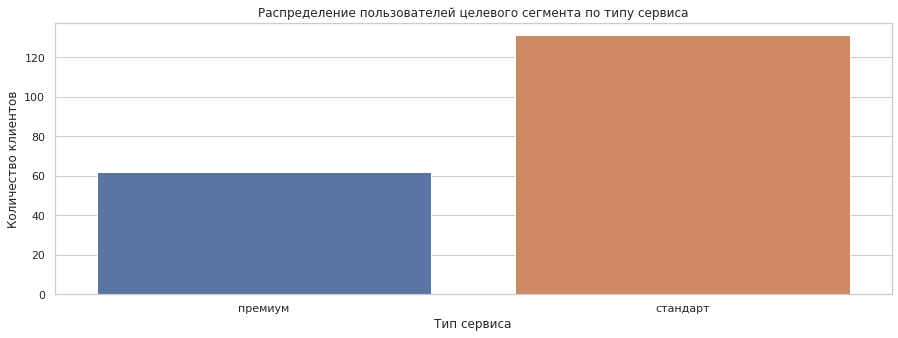

In [118]:
countplot_creator(target_users, 'тип_сервиса', 'Распределение пользователей целевого сегмента по типу сервиса', 'Количество клиентов', 'Тип сервиса')

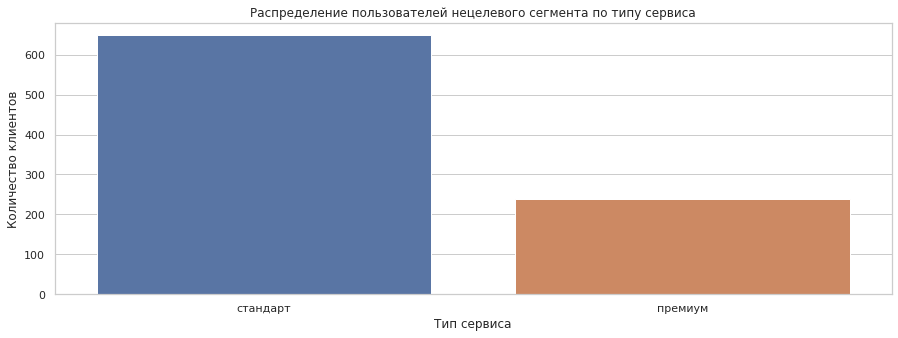

In [119]:
countplot_creator(non_targeted_users, 'тип_сервиса', 'Распределение пользователей нецелевого сегмента по типу сервиса', 'Количество клиентов', 'Тип сервиса')

Доля класса "Премиум" в целевом сегменте, похоже, выше, чем в нецелевом. Может, будет не лишним провести опрос среди пользователей "Премиума", чего не хватает в обслуживании.

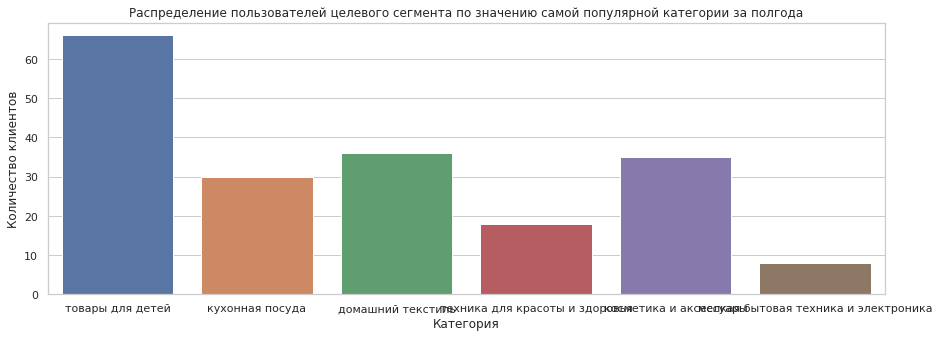

In [123]:
countplot_creator(target_users, 'популярная_категория', 'Распределение пользователей целевого сегмента по значению самой популярной категории за полгода', 'Количество клиентов', 'Категория')

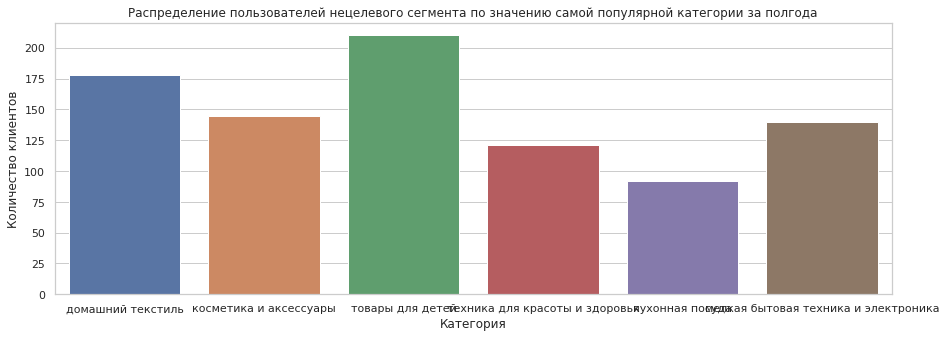

In [124]:
countplot_creator(non_targeted_users, 'популярная_категория', 'Распределение пользователей нецелевого сегмента по значению самой популярной категории за полгода', 'Количество клиентов', 'Категория')

Кажется, нечего отметить. <font color='green'>Как мы выяснили, акции хорошо подстегнули целевой сегмент совершать больше покупок в прошлом месяце. В таком случае мы увидим рост суммарной выручки, если посмотрим на категории в разрезе по периодам.</font>

In [125]:
target_users.pivot_table(index='популярная_категория', values=['money_before_last_month', 'money_last_month', 'money_current_month'], aggfunc='sum')

,money_before_last_month,money_current_month,money_last_month
популярная_категория,,,
домашний текстиль,164851.0,193845.2,182276.5
косметика и аксессуары,161228.0,194775.6,181883.5
кухонная посуда,140686.0,174530.4,160694.5
мелкая бытовая техника и электроника,37522.0,44640.8,41461.0
техника для красоты и здоровья,82460.0,84482.6,76654.0
товары для детей,302645.0,330688.6,308995.5


<font color='green'>Наблюдаем, что в период акции целевой сегмент стал значительно активнее приносить выручку в категориях: домашний текстиль, косметика и аксессуары и кухонная посуда.</font>

**Итоги сегментации**:

На данном этапе был выделен сегмент покупателей с наибольшей вероятностью снижения активности (от 0.80) и наибольшей среднемесячной прибылью (значения от 3-ёх).

**Исходя из анализа целевого сегмента, отметим следующее:**

- <font color='green'> В среднем с целевым сегментом меньше коммуникаций, но если он в целом сходен с портретом целевого покупателя, то покупатели из целевого сегмента просто меньше проводят времени на сайте.
</font>
- Целевой сегмент реже просматривает больше трёх категорий. <font color='green'> Опять же объясняется это меньшей заинтересованностью в взаимодействии с сайтом.</font>
- <font color='green'> Есть сходство с общим портретом клиентов со снизившейся активностью: целевой сегмент чаще имеет значения больше пяти неоплаченных товаров в корзине.
</font>
- <font color='green'>Целевой сегмент чаще составляют пользователи  с долей акционных покупок больше 0.3. Похоже, что целевой сегмент в этом сходен с общим портретом пользователей со снизившейся активностью. Если так, то мы должны увидеть рост средней выручки от сегмента от позапрошлого месяца к прошлому.</font>
- Выручка за предпредыдущий месяц от целевого сегмента в среднем была ниже. А вот за прошлый месяц и текущий распределение довольно похожее. Да и в целом значения выручки выше. Вероятно это результат какой-то маркетинговой кампании.  <font color='green'>Акции очевидно хороший способ поднять активность целевого сегмента. Изучив разницу в выручке среди популярных категорий товаров, мы обнаружили, что в период акции целевой сегмент стал значительно активнее приносить выручку в категориях: домашний текстиль, косметика и аксессуары и кухонная посуда. Можно поднять активность целевого сегмента, если предлагать специальные предложения для товаров в данных категориях.</font>
- Доля класса "Премиум" в целевом сегменте, похоже, выше, чем в нецелевом. Может, будет не лишним провести опрос среди пользователей "Премиума", чего не хватает в обслуживании.

[Назад к содержанию](#0)

<a id="9"><a/>
## Общий вывод

Цель компании «В один клик» — удерживать активность постоянных клиентов.

Исходя из этой цели, были сформулированы основные задачи проекта:
- Создать модель МО, которая будет предсказывать: изменилась ли покупательская активность постоянных пользователей.
- Изучить сегмент пользователей с высокой вероятностью снижения активности и дать предложения для её поддержания.

**Для выполнения задач были проделаны следующие шаги:**

**1  Загрузка данных**

Исходные данные были переданы следующим переменным:

- **market_main**: данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- **market_money**: данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- **market_time**: данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- **money_mean_month**: данные о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**market_main**:
- Датафрейм **market_main** содержит 1300 наблюдений по 9-ти признакам.
- По сводной статистике не выявили аномальных значений.
- В признаке "Тип сервиса" выявили неявный дубликат среди значений.

**market_money**: датафрейм market_money содержит 3900 наблюдений по трём признакам.

**market_time**: датафрейм market_time состоит из 2600 строк по трём признакам.

**money_mean_month**: датафрейм money_mean_month содержит 1300 строк наблюдений по двум признакам.

**2 Предобработка данных**

- Удалён неявный дубликат "стандартт" в признаке тип_сервиса.
- Названия столбцов и значений сделаны более однотипными.
- Внесены лёгкие эстетически правки.

**3  Исследовательский анализ данных**

**market_main**:

**Количественные признаки:**
- **маркет_актив_6_мес**: значения от 0.9 до 6.6. Значения менее, чем примерно 2.4, воспринимаются ящиком с усами как статистические выбросы. Для решеня проблем с выбросами решено ввести новый категориальный признак.<font color='green'> Отметим, что значения от 1 до 3 принадлежат пользователям в большей части со снизившейся активностью. Это могут быть пользователи, которые в целом редко посещают сайт. </font>
- **маркет_актив_тек_мес**: значения от 3 до 5. Значения 3 и 5 воспринимаются как выбросы, для решения проблемы введён категориальный признак.
- **длительность**: распределение значений: 110—1079 дней. Распределение близко к нормальному.
- **акционные_покупки**: значения от 0 до 0.99. На гистограмме наблюдаем два пика. Можно разделить покупателей на две группы: обычные клиенты и те, кто почти всегда берёт товары только по акции. <font color='green'>Причём высокая доля акционных покупок больше характерна для пользователей со снизившейся активностью. Можно сказать, что у интересующей нас категории покупателей вероятнее снижается активность после завершения акций. Вероятно некоторые категории клиентов получали специальные предложения, иначе бы график был бы более близок к нрмальному распределению.</font>
- **средний_просмотр_категорий_за_визит**: Значения от 1-го до 6-ти. Распределение на гистограмме похоже на нормальное, смещено влево. <font color='green'> Пользователи со снизившейся активностью в среднем просматривают меньше категорий. В целом уже можно предположить, что низкая активность на сайте более характерна для интересующей нас категории покупателей.</font>
- **неоплаченные_продукты_штук_квартал**: Значения от 0 до 10-ти. Значения больше 8-ми являются статистическими выбросами. <font color='green'> Значения больше пяти более характерныны для пользователей со снизившейся активностью.</font>
- **ошибка_сервиса**: Значения от 0 до 9-ти. Наблюдаем нормальное распределение. <font color='green'> Пользователи со снизившейся активностью реже сталкиваются с высокими значениями сбоев. Вероятно в силу того, что они в целом меньше взаимодействуют с сайтом.</font>
- **страниц_за_визит**: Значения от 1-ой до 20-ти страниц. Наблюдаем нормальное распределение со смещением влево. Выбросы отсутствуют. <font color='green'>Как и предполагалось, пользователи со снизившейся активностью просматривают меньше страниц.</font>

На основе изученных количественных признаков в датафрейм введены следующие категориальные признаки:
- **market_active_mean_cat**: на основе данных признака **маркет_актив_6_мес** введены категориальные значения со следующим распределением: меньше 3 — 9.92%, 3—5 — 66.31%, больше 5 — 23.77%.
- **market_active_last_cat**: на основе данных признака **маркет_актив_тек_мес** введены категориальные значения со следующим распределением: три — 23.69%, четыре — 51.46%, пять — 24.85%.
- **promotional_purchases_cat**: на основе данных признака **акционные_покупки** введены категориальные значения со следующим распределением: регулярный покупатель — 87.15%, акционный покупатель — 12.85%.
- **unpaid_products_cat**: на основе данных признака **неоплаченные_продукты_штук_квартал** введены категориальные значения со следующим распределением: не было неоплаченных товаров — 8.92%, один — 20.08%, два — 20.08%, три — 16.77%, четыре — 15.15%, пять — 10.38%, больше пяти — 8.62%.

**Категориальные признаки:**
- **покупательская_активность**: прежний уровень — 61.69% клиентов, снизилась — 38.31%.
- **тип_сервиса**: стандарт — 71.08% клиентов, премиум — 28.92%. <font color='green'>Среди пользователей со снизившейся активностью доля пользователей с обслуживанием "Премиум" почти такая же как у пользователей со стандартным обслуживанием. Кажется, условия обслуживания "Премиум" не столь эфективно поддерживают активность, как моно было бы ожидать. </font>
- **разрешить_сообщать**: да — 74% клиентов, нет — 26%. <font color='green'> Пользователи чаще соглашаются принимать дополнительные предложения. Для интересующей нас категории покупателей это так же характерно.</font>
- **популярная_категория**: товары для детей — 25.38% клиентов, домашний текстиль — 19.31%, косметика и аксессуары — 17.15%, техника для красоты и здоровья — 14.15%, мелкая бытовая техника и электроника — 13.38%, кухонная посуда — 10.62%. <font color='green'>Доля пользователей со снизившейся активностью заметно ниже только среди категорий бытовой теники и техники для красоты и здоровья. Возможно, товары из остальных категории чаще оказываются в центре маркетинговых компаний или в специальных предложениях для пользователей.</font>

**market_money**:

- Обнаружили у пользователя 215380 сильный выброс в значениях выручки. Данные данного пользователя убрали из всех таблиц.
- <font color='green'>В позапрошлом месяце средняя выручка от пользователей со снизившейся активностью была заметно ниже, чем у активных. Начиная с прошлого месяца значения примерно выравнялись, да и в целом пользователи стали тратить больше. Возможно в прошлом месяце началась какая-то маркетинговая кампания.</font>

**market_time**:
- **минут**: распределение значений от 4-х до 23-х. На гистограмме наблюдаем нормальное распределене, выбросы отсутствуют.
- **период**: два значения "текущий месяц" и "предыдущий месяц" равно распределены: по 1300 значений.
- <font color='green'>Пользователи со снизившейся активностью чаще проводят на сайте меньше времени.</font>

**money_mean_month**: Значения прибыли от 0.86 до 7.43. Наблюдаем нормальное распределение.

<font color='green'>
<b>По итогу анализа составили следующий портрет пользователя со снизившейся активностью:</b>
    
- В целом меньше взаимодействий с сайтом: в среднем около 10-12 минут в месяц, просматривают меньше категорий за визит, меньше страниц.
- Чаще совершают покупки по акции.
- Чаще имеют в корзине больше пяти неоплаченных товаров за квартал.
- Чаще заинтересованы в следующих категориях товаров: товары для детей, косметика и аксессуары, домашний текстиль, кухонная посуда.
- Обладают типом обслуживания "Премиум" почти так же часто, как и стандартные пользователи.

</font>

В конце исследовательского анализа отобрали активных покупателей: убрали из таблиц клиентов с нулевой выручкой хотя бы в один из месяцев.

**4  Объединение таблиц**

Объединили данные **market_main**, **market_money** и **market_time** в одну таблицу.

**5  Корреляционный анализ**

Избавились от признаков введённых прежде на этапе анализа данных категориальных признаков.

**6  Использование пайплайнов**

На данном этапе был создан пайплайн для подбора модели с лучшей предсказательной способностью. Для оценки качества модели была использована метрика ROC-AUC, так как она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного. 

<font color='green'>
Лучше всех метрика качества у дерева решений с 3-мя уровнями с правилами и 4-мя признаками.</font>

<font color='green'>
Метрика лучшей модели на кросс-валидации: 0.8482418149554514

Метрика ROC-AUC на тестовой выборке: 0.8891315778829431</font>

**7  Анализ важности признаков**

Создали график важности признаков и график SHAP-значений признаков.

<font color='green'>
<b>Модель принимает решения на основе 4-ёх признаков:</b>
    
- Количество страниц за визит: самый важный признак.
- Доля акционных покупок.
- Выручка за позапрошлый месяц.
- Среднее число маркетинговых коммуникаций за полгода.

**Из анализа графика SHAP-значений отметили следующее:**

- **Количество страниц за визит**: малые значения увеличивают вероятность принадлежности к классу "снизилась".
- **Доля акционных покупок**: большие значения увеличивают вероятность принадлежности к классу "снизилась".
- **Выручка за позапрошлый месяц**: малые значения увеличивают вероятность принадлежности к классу "снизилась".
- **Среднее число маркетинговых коммуникаций за полгода**: большие значения увеличивают вероятность принадлежности к классу "снизилась".</font>

**8  Сегментация покупателей**

**Итоги сегментации**:

На данном этапе был выделен сегмент покупателей с наибольшей вероятностью снижения активности (от 0.80) и наибольшей среднемесячной прибылью (значения от 3-ёх).

**Исходя из анализа целевого сегмента вывели его отличительные особенности и сформировали несколько предложений для повышения активности:**

- <font color='green'> В среднем с целевым сегментом меньше коммуникаций, но если он в целом сходен с портретом целевого покупателя, то покупатели из целевого сегмента просто меньше проводят времени на сайте.
</font>
- Целевой сегмент реже просматривает больше трёх категорий. <font color='green'> Опять же объясняется это меньшей заинтересованностью в взаимодействии с сайтом.</font>
- <font color='green'> Есть сходство с общим портретом клиентов со снизившейся активностью: целевой сегмент чаще имеет значения больше пяти неоплаченных товаров в корзине.
</font>
- <font color='green'>Целевой сегмент чаще составляют пользователи  с долей акционных покупок больше 0.3. Похоже, что целевой сегмент в этом сходен с общим портретом пользователей со снизившейся активностью. Если так, то мы должны увидеть рост средней выручки от сегмента от позапрошлого месяца к прошлому.</font>
- Выручка за предпредыдущий месяц от целевого сегмента в среднем была ниже. А вот за прошлый месяц и текущий распределение довольно похожее. Да и в целом значения выручки выше. Вероятно это результат какой-то маркетинговой кампании.  <font color='green'>Акции очевидно хороший способ поднять активность целевого сегмента. Изучив разницу в выручке среди популярных категорий товаров, мы обнаружили, что в период акции целевой сегмент стал значительно активнее приносить выручку в категориях: домашний текстиль, косметика и аксессуары и кухонная посуда. Можно поднять активность целевого сегмента, если предлагать специальные предложения для товаров в данных категориях.</font>
- Доля класса "Премиум" в целевом сегменте, похоже, выше, чем в нецелевом. Может, будет не лишним провести опрос среди пользователей "Премиума", чего не хватает в обслуживании.